What is a LiDAR?

LiDAR, or light detection and ranging, is a popular remote sensing method used for measuring the exact distance of an object on the earth’s surface. There are three primary components of a LiDAR instrument — the scanner, laser and GPS receiver.

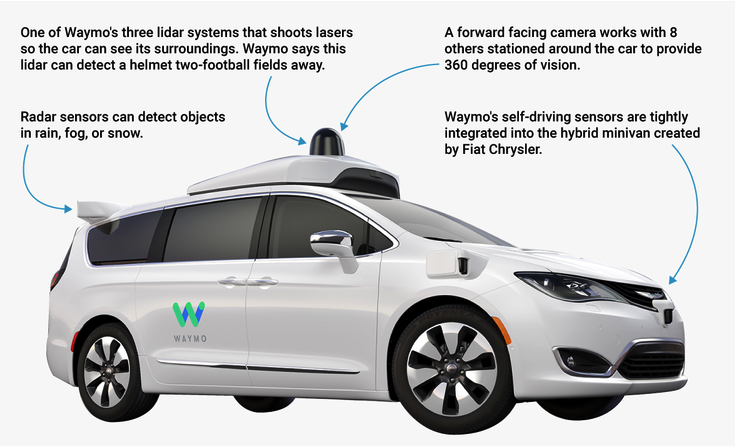


Continuously rotating LiDAR system sends thousands of laser pulses every second. These pulses collide with the surrounding objects and reflect back. The resulting light reflections are then used to create a 3D point cloud.

When it comes to sensing the vehicle’s surroundings with a 360-degree field of view, LIDAR-based systems are highly accurate in object detection and recognition of 3D shapes, even for longer distances (100-200 meters). LIDAR system’s 3D mapping capability also helps in differentiating between cars, pedestrians, trees, people, or other objects, while also calculating and sharing details of their velocity in real time.






**Data Visualization**

In [ ]:
!ls ../input/3d-object-detection-for-autonomous-vehicles


In [ ]:
!pip install lyft_dataset_sdk


**Data**

You will need the LIDAR, image, map and data files for both train and test (test_images.zip, test_lidar.zip, etc.). You may also need the train.csv, which includes the sample annotations in the form expected for submissions. The sample_submission.csv file contains all of the sample Ids for the test set.

The data files (test_data.zip, train_data.zip) are in JSON format.



train_data.zip and test_data.zip - contains JSON files with multiple tables. 

train_images.zip and test_images.zip - contains .jpeg files corresponding to samples in sample_data.json

train_lidar.zip and test_lidar.zip - contains .jpeg files corresponding to samples in sample_data.json

train_maps.zip and test_maps.zip - contains maps of the entire sample area.

train.csv - contains all sample_tokens in the train set, as well as annotations in the required format for all train set objects.

sample_submission.csv - contains all sample_tokens in the test set, with empty predictions.

**Dataset Structure**

scene - 25-45 seconds snippet of a car's journey.

sample - An annotated snapshot of a scene at a particular timestamp.

sample_data - Data collected from a particular sensor.

sample_annotation - An annotated instance of an object within our interest.

instance - Enumeration of all object instance we observed.

category - Taxonomy of object categories (e.g. vehicle, human).

attribute - Property of an instance that can change while the category remains the same.

visibility - (currently not used)

sensor - A specific sensor type.

calibrated sensor - Definition of a particular sensor as calibrated on a particular vehicle.

ego_pose - Ego vehicle poses at a particular timestamp.

log - Log information from which the data was extracted.

map - Map data that is stored as binary semantic masks from a top-down view.

**Load all the necessary libraries**

In [ ]:


import numpy as np
import pandas as pd
import os
import gc


import json
import math 
import sys
from datetime import datetime
import time
from typing import Tuple,List

import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import sklearn.metrics
from PIL import Image

from matplotlib.axes import Axes
from matplotlib import animation, rc
import plotly.graph_objs as go
import plotly.tools as ts
from plotly.offline import plot, init_notebook_mode
import plotly.figure_factory as ft
init_notebook_mode(connected=True)
from pyquaternion import Quaternion
import seaborn as sns
from tqdm import tqdm 
import warnings

from lyft_dataset_sdk.utils.map_mask import MapMask
from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.geometry_utils import view_points, box_in_image, BoxVisibility
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix
from pathlib import Path

import struct
from abc import ABC, abstractmethod
from functools import reduce
from typing import Tuple, List, Dict
import copy

plt.rcParams['figure.figsize']=[16,10]
plt.rcParams['font.size']=14
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 99
sns.set_palette(sns.color_palette('tab20', 20))

In [ ]:
#Path to the dataset
#Path= '../input/3d-object-detection-for-autonomous-vehicles/'
DATA_PATH = '../input/3d-object-detection-for-autonomous-vehicles/'


In [ ]:
#Load the train dataset
train=pd.read_csv(DATA_PATH+'train.csv')

In [ ]:
train.head()

In [ ]:
#Load sample submission
sample_submission=pd.read_csv(DATA_PATH+'sample_submission.csv')
sample_submission.head()

In [ ]:
print(f'Training Data : {train.shape}, Sample Submission Data : {sample_submission.shape}')

The annotations in train.csv:

center_x, center_y and center_z are the world coordinates of the center of the 3D bounding volume.

width, length and height are the dimensions of the volume.

yaw is the angle of the volume around the z axis (where y is forward/back, x is left/right, and z is up/down - making 'yaw' the direction the front of the vehicle / bounding box is 
pointing at while on the ground).

class_name is the type of object contained by the bounding volume.

We have 638K annotated objects in 22K train samples.

In [ ]:
#Check the parsing of prediction String
max([len(ps.split(' ')) %8 for ps in train.PredictionString.values])

In [ ]:
!ln -s /kaggle/input/3d-object-detection-for-autonomous-vehicles/train_images images
!ln -s /kaggle/input/3d-object-detection-for-autonomous-vehicles/train_maps maps
!ln -s /kaggle/input/3d-object-detection-for-autonomous-vehicles/train_lidar lidar

In [ ]:
level5data = LyftDataset(data_path='.', json_path='/kaggle/input/3d-object-detection-for-autonomous-vehicles/train_data', verbose=True)

**Group data by Object Category**

In [ ]:
object_columns = ['sample_id', 'object_id', 'center_x', 'center_y', 'center_z',
                  'width', 'length', 'height', 'yaw', 'class_name']
objects = []
for sample_id, ps in tqdm(train.values[:]):
    object_params = ps.split()
    n_objects = len(object_params)
    for i in range(n_objects // 8):
        x, y, z, w, l, h, yaw, c = tuple(object_params[i * 8: (i + 1) * 8])
        objects.append([sample_id, i, x, y, z, w, l, h, yaw, c])
train_objects = pd.DataFrame(
    objects,
    columns = object_columns
)

In [ ]:
objects

**Convert numerical features from str to float32**

In [ ]:
numerical_cols = ['object_id', 'center_x', 'center_y', 'center_z', 'width', 'length', 'height', 'yaw']
train_objects[numerical_cols] = np.float32(train_objects[numerical_cols].values)

In [ ]:
train_objects

**Data Exploration**

centre_x is the x coordinate 

centre_y is the y coordinate

In [ ]:
#Lets see the distribution of center_x and center_y

fig,ax=plt.subplots(figsize=(10,10))
sns.distplot(train_objects['center_x'],color='blue',ax=ax).set_title('center_x and center_y', fontsize=10)
sns.distplot(train_objects['center_y'],color='pink',ax=ax).set_title('center_x and center_y', fontsize=10)
plt.xlabel("center_x and center_y")
plt.show()

Observation : 

1. The distributions of both center_x and center_y have multiple peaks, hence its multimodal.

2. The distribution of center_y(pink) has a signficantly higher skew that the the distribution of center_x (blue). 

3. The center_x distribution is more evenly spread out.

4. This indicates that objects are spread out very evenly along the x-axis, but not likewise along the y-axis. This is probably because the car's camera can sense objects on either left or right easily (along the x-axis) due to the width of the road being small. But, since the length of the road is much greater than its width, and there is a higher chance of the camera's view being blocked from this angle, the camera can only find objects narrowly ahead or narrowly behind (and not further away).

**Relationship between center_x and center_y**

In [ ]:
n_train_objects=train_objects.query('class_name=="car"')
sns.jointplot(x=n_train_objects['center_x'][:1000], y=n_train_objects['center_y'][:1000],kind='kde',color="green").set_axis_labels('center_x','center_y',fontsize=10)
plt.show()


Observation : 

1. This shows a negative correlation between center_x and center_y.

2. The camera cannot detect objects that are both far ahead and far to the side. Because of this, objects that are far ahead and far to the side are not detected at all, and only objects which satisfy one (or none) of those conditions are detected.

**Distribution of center_z** : 
z coordinate represents the height of the object above the x-y plane.

In [ ]:
fig,ax=plt.subplots(figsize=(10,10))
sns.distplot(train_objects['center_z'],color='blue',ax=ax).set_title('center_x and center_y', fontsize=10)
plt.xlabel("center_z")
plt.show()

Observation :  The distribution of center_z has an extremely high positive (rightward) skew and is clustered around the -20 mark (its mean value). Most z coordinates are negative because the camera is attached at the top of the car. So, most of the times, the camera has to "look down" to see the objects. Therefore, the height or z-coordinate of the objects relative to the camera are generally negative.

In [ ]:
fig,ax=plt.subplots(figsize=(10,10))
sns.distplot(train_objects['yaw'],color='darkorange',ax=ax).set_title('yaw', fontsize=10)
plt.xlabel("yaw")
plt.show()

Observations : The distribution of yaw is roughly bimodal and the the mean is between 1 and 2

**Width**

width is the width of the bounding volume in which the object lies.

In [ ]:
fig,ax=plt.subplots(figsize=(10,10))
sns.distplot(train_objects['width'],color='pink',ax=ax).set_title('width', fontsize=10)
plt.xlabel("width")
plt.show()

Observations : The width is approximately normally distirbuted with a mean of around 2, with some outliers on either side. The majority of the objects are cars, and these constitute a width of around 2 ( peak). The outliers on the right represent larger objecs like trucks and vans, and the outliers on the left represent smaller objects like pedestrians and bicycles.

**Length**

length is the length of the bounding volume in which the object lies.



In [ ]:
fig,ax=plt.subplots(figsize=(10,10))
sns.distplot(train_objects['length'],color='magenta',ax=ax).set_title('length', fontsize=10)
plt.xlabel("Length")
plt.show()

Observations : the length has a distribution with a strong positive (right skewed) with a mean of around 5, with some outliers on either side. The majority of the objects are cars (as we will see later), and these constitute a length of around 5 (at the peak). The outliers on the right represent larger objecs like trucks and vans, and the outliers on the left represent smaller objects like pedestrians and bicycles.

**Height**

height is the height of the bounding volume in which the object lies.

In [ ]:
fig,ax=plt.subplots(figsize=(10,10))
sns.distplot(train_objects['height'],color='green',ax=ax).set_title('height', fontsize=10)
plt.xlabel("Height")
plt.show()

Observations : the height has a distribution with a strong positive (rightward skew) with a mean of around 2, with some outliers on either side. The majority of the objects are cars , and these constitute a length of around 2 ( peak). The outliers on the right represent larger objecs like trucks and vans, and the outliers on the left represent smaller objects like pedestrians and bicycles.

In [ ]:
#Calculate Object frequencies

fig, ax = plt.subplots(figsize=(10, 10))
plot = sns.countplot(y="class_name", data=train_objects.query('class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"'),
                     palette=['navy', 'darkblue', 'blue', 'dodgerblue', 'skyblue', 'lightblue']).set_title('Object Frequencies', fontsize=16)
plt.yticks(fontsize=14)
plt.xlabel("Count", fontsize=15)
plt.ylabel("Class Name", fontsize=15)
plt.show(plot)

Observation : most common object class in the dataset is "car"

**Width vs Class Name**

In [ ]:
fig,ax=plt.subplots(figsize=(16,10))
sns.violinplot(x="class_name", y="width", data= train_objects.query('class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"'),\
              palette='Set2',split=True, ax=ax).set_title("Width vs Class Name", fontsize=10)
plt.xlabel("Class Name")
plt.show()

Observation : The width distributions for large vehicles like cars, buses, and trucks have much larger means as compared to small objects like pedestrians and bicycles.

**Length vs Class Name**

In [ ]:
fig,ax=plt.subplots(figsize=(16,10))
sns.violinplot(x="class_name", y='length', data=train_objects.query('class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"'),\
              palette='Set2',split=True, ax=ax).set_title("Length vs Class Name", fontsize=10)
plt.xlabel("Class Name ")
plt.show()

Observation : the length distributions for large vehicles like cars, buses, and trucks have much larger means as compared to small objects like pedestrians and bicycles.

**Height vs Class Name**

In [ ]:
fig,ax=plt.subplots(figsize=(16,10))
sns.violinplot(x="class_name", y='height', data=train_objects.query('class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"'),\
              palette='Set2',split=True, ax=ax).set_title("Height vs Class Name", fontsize=10)
plt.xlabel("Class Name ")
plt.show()

Observations : the height distributions for large vehicles like buses and trucks have much larger means as compared to small objects like pedestrians and bicycles. 

**Centre_x, Centre_y, Center_z vs Class Name**

In [ ]:
fig,ax=plt.subplots(figsize=(16,10))
sns.violinplot(x="class_name", y='center_x', data=train_objects.query('class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"'),\
              palette='Set2',split=True, ax=ax).set_title("Center_x vs Class Name", fontsize=10)
plt.xlabel("Class Name ")
plt.show()

In [ ]:
fig,ax=plt.subplots(figsize=(16,10))
sns.violinplot(x="class_name", y='center_y', data=train_objects.query('class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"'),\
              palette='Set2',split=True, ax=ax).set_title("Center_y vs Class Name", fontsize=10)
plt.xlabel("Class Name ")
plt.show()

In [ ]:
fig,ax=plt.subplots(figsize=(16,10))
sns.violinplot(x="class_name", y='center_z', data=train_objects.query('class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"'),\
              palette='Set2',split=True, ax=ax).set_title("Center_z vs Class Name", fontsize=10)
plt.xlabel("Class Name ")
plt.show()

Observations :

1. The distributions of center_x for large vehicles including trucks, buses, and other vehicles are well spread. They barely have any skew and have greater means than the distributions for pedestrians and bicycles. This is probably because these large vehicles tend to keep greater distances from the other vehicles, and the smaller vehicles do not stay too close to these large vehicles in order to avoid accidents. Therefore, the mean center_x is clearly greater for larger vehicles like buses and trucks.

2. the distributions of center_y for small objects including pedestrians and bicycles have a greater mean value than large objects like trucks and buses. The distributions for the small objects have much greater probability density concentrated at higher values of center_y as compared to large objects. This signifies that small objects, in general, have greater center_y values than large objects.

3. the distributions of center_z for small objects including pedestrians and bicycles have a significantly smaller mean value than large objects like trucks and buses. The distributions for the small objects have much greater probability density concentrated at lower values of center_z as compared to large objects. This signifies that small objects, in general, have smaller center_y values than large objects.

# LiDAR and Image Data 

In [ ]:
!pip install lyft-dataset-sdk -q

In [ ]:
from datetime import datetime
from functools import partial
import glob
from multiprocessing import Pool

# Disable multiprocesing for numpy/opencv. We already multiprocess ourselves, this would mean every subprocess produces
# even more threads which would lead to a lot of context switching, slowing things down a lot.
import os
os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import cv2
from PIL import Image
import numpy as np
from tqdm import tqdm, tqdm_notebook
import scipy
import scipy.ndimage
import scipy.special
from scipy.spatial.transform import Rotation as R
from pathlib import Path

from lyft_dataset_sdk.lyftdataset import LyftDataset,LyftDatasetExplorer
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud, Box, Quaternion
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix
import time
from lyft_dataset_sdk.utils.map_mask import MapMask

In [ ]:
!ln -s /kaggle/input/3d-object-detection-for-autonomous-vehicles/test_images images
!ln -s /kaggle/input/3d-object-detection-for-autonomous-vehicles/test_maps maps
!ln -s /kaggle/input/3d-object-detection-for-autonomous-vehicles/test_lidar lidar

In [ ]:
class LyftTestDataset(LyftDataset):
    """Database class for Lyft Dataset to help query and retrieve information from the database."""

    def __init__(self, data_path: str, json_path: str, verbose: bool = True, map_resolution: float = 0.1):
        """Loads database and creates reverse indexes and shortcuts.
        Args:
            data_path: Path to the tables and data.
            json_path: Path to the folder with json files
            verbose: Whether to print status messages during load.
            map_resolution: Resolution of maps (meters).
        """

        self.data_path = Path(data_path).expanduser().absolute()
        self.json_path = Path(json_path)

        self.table_names = [
            "category",
            "attribute",
            "sensor",
            "calibrated_sensor",
            "ego_pose",
            "log",
            "scene",
            "sample",
            "sample_data",
            "map",
        ]

        start_time = time.time()

        # Explicitly assign tables to help the IDE determine valid class members.
        self.category = self.__load_table__("category")
        self.attribute = self.__load_table__("attribute")
        
        
        self.sensor = self.__load_table__("sensor")
        self.calibrated_sensor = self.__load_table__("calibrated_sensor")
        self.ego_pose = self.__load_table__("ego_pose")
        self.log = self.__load_table__("log")
        self.scene = self.__load_table__("scene")
        self.sample = self.__load_table__("sample")
        self.sample_data = self.__load_table__("sample_data")
        
        self.map = self.__load_table__("map")

        # Initialize map mask for each map record.
        for map_record in self.map:
            map_record["mask"] = MapMask(self.data_path / map_record["filename"], resolution=map_resolution)

        if verbose:
            for table in self.table_names:
                print("{} {},".format(len(getattr(self, table)), table))
            print("Done loading in {:.1f} seconds.\n======".format(time.time() - start_time))

        # Initialize LyftDatasetExplorer class
        self.explorer = LyftDatasetExplorer(self)
        # Make reverse indexes for common lookups.
        self.__make_reverse_index__(verbose)
        
    def __make_reverse_index__(self, verbose: bool) -> None:
        """De-normalizes database to create reverse indices for common cases.
        Args:
            verbose: Whether to print outputs.
        """

        start_time = time.time()
        if verbose:
            print("Reverse indexing ...")

        # Store the mapping from token to table index for each table.
        self._token2ind = dict()
        for table in self.table_names:
            self._token2ind[table] = dict()

            for ind, member in enumerate(getattr(self, table)):
                self._token2ind[table][member["token"]] = ind

        # Decorate (adds short-cut) sample_data with sensor information.
        for record in self.sample_data:
            cs_record = self.get("calibrated_sensor", record["calibrated_sensor_token"])
            sensor_record = self.get("sensor", cs_record["sensor_token"])
            record["sensor_modality"] = sensor_record["modality"]
            record["channel"] = sensor_record["channel"]

        # Reverse-index samples with sample_data and annotations.
        for record in self.sample:
            record["data"] = {}
            record["anns"] = []

        for record in self.sample_data:
            if record["is_key_frame"]:
                sample_record = self.get("sample", record["sample_token"])
                sample_record["data"][record["channel"]] = record["token"]

        # Add reverse indices from log records to map records.
        if "log_tokens" not in self.map[0].keys():
            raise Exception("Error: log_tokens not in map table. This code is not compatible with the teaser dataset.")
        log_to_map = dict()
        for map_record in self.map:
            for log_token in map_record["log_tokens"]:
                log_to_map[log_token] = map_record["token"]
        for log_record in self.log:
            log_record["map_token"] = log_to_map[log_record["token"]]

        if verbose:
            print("Done reverse indexing in {:.1f} seconds.\n======".format(time.time() - start_time))

In [ ]:
level5data = LyftTestDataset(data_path='.', json_path='/kaggle/input/3d-object-detection-for-autonomous-vehicles/test_data', verbose=True)
# Our code will generate data, visualization and model checkpoints, they will be persisted to disk in this folder
ARTIFACTS_FOLDER = "./artifacts"
os.makedirs(ARTIFACTS_FOLDER, exist_ok=True)
classes = ["car", "motorcycle", "bus", "bicycle", "truck", "pedestrian", "other_vehicle", "animal", "emergency_vehicle"]

In [ ]:
def create_transformation_matrix_to_voxel_space(shape, voxel_size, offset):
    """
    Constructs a transformation matrix given an output voxel shape such that (0,0,0) ends up in the center.
    Voxel_size defines how large every voxel is in world coordinate, (1,1,1) would be the same as Minecraft voxels.
    
    An offset per axis in world coordinates (metric) can be provided, this is useful for Z (up-down) in lidar points.
    """
    
    shape, voxel_size, offset = np.array(shape), np.array(voxel_size), np.array(offset)
    
    tm = np.eye(4, dtype=np.float32)
    translation = shape/2 + offset/voxel_size
    
    tm = tm * np.array(np.hstack((1/voxel_size, [1])))
    tm[:3, 3] = np.transpose(translation)
    return tm

def transform_points(points, transf_matrix):
    """
    Transform (3,N) or (4,N) points using transformation matrix.
    """
    if points.shape[0] not in [3,4]:
        raise Exception("Points input should be (3,N) or (4,N) shape, received {}".format(points.shape))
    return transf_matrix.dot(np.vstack((points[:3, :], np.ones(points.shape[1]))))[:3, :]


In [ ]:
def car_to_voxel_coords(points, shape, voxel_size, z_offset=0):
    if len(shape) != 3:
        raise Exception("Voxel volume shape should be 3 dimensions (x,y,z)")
        
    if len(points.shape) != 2 or points.shape[0] not in [3, 4]:
        raise Exception("Input points should be (3,N) or (4,N) in shape, found {}".format(points.shape))

    tm = create_transformation_matrix_to_voxel_space(shape, voxel_size, (0, 0, z_offset))
    p = transform_points(points, tm)
    return p

def create_voxel_pointcloud(points, shape, voxel_size=(0.5,0.5,1), z_offset=0):

    points_voxel_coords = car_to_voxel_coords(points.copy(), shape, voxel_size, z_offset)
    points_voxel_coords = points_voxel_coords[:3].transpose(1,0)
    points_voxel_coords = np.int0(points_voxel_coords)
    
    bev = np.zeros(shape, dtype=np.float32)
    bev_shape = np.array(shape)

    within_bounds = (np.all(points_voxel_coords >= 0, axis=1) * np.all(points_voxel_coords < bev_shape, axis=1))
    
    points_voxel_coords = points_voxel_coords[within_bounds]
    coord, count = np.unique(points_voxel_coords, axis=0, return_counts=True)
        
    # Note X and Y are flipped:
    bev[coord[:,1], coord[:,0], coord[:,2]] = count
    
    return bev

def normalize_voxel_intensities(bev, max_intensity=16):
    return (bev/max_intensity).clip(0,1)

In [ ]:
bev_shape = (336, 336, 3)
target_im = np.zeros(bev_shape, dtype=np.uint8)

def move_boxes_to_car_space(boxes, ego_pose):
    """
    Move boxes from world space to car space.
    Note: mutates input boxes.
    """
    translation = -np.array(ego_pose['translation'])
    rotation = Quaternion(ego_pose['rotation']).inverse
    
    for box in boxes:
        # Bring box to car space
        box.translate(translation)
        box.rotate(rotation)
        
def scale_boxes(boxes, factor):
    """
    Note: mutates input boxes
    """
    for box in boxes:
        box.wlh = box.wlh * factor

def draw_boxes(im, voxel_size, boxes, classes, z_offset=0.0):
    for box in boxes:
        # We only care about the bottom corners
        corners = box.bottom_corners()
        corners_voxel = car_to_voxel_coords(corners, im.shape, voxel_size, z_offset).transpose(1,0)
        corners_voxel = corners_voxel[:,:2] # Drop z coord

        class_color = classes.index(box.name) + 1
        
        if class_color == 0:
            raise Exception("Unknown class: {}".format(box.name))

        cv2.drawContours(im, np.int0([corners_voxel]), 0, (class_color, class_color, class_color), -1)

In [ ]:
def visualize_lidar_of_sample(sample_token, axes_limit=80):
    sample = level5data.get("sample", sample_token)
    sample_lidar_token = sample["data"]["LIDAR_TOP"]
    level5data.render_sample_data(sample_lidar_token, axes_limit=axes_limit)
    
# Don't worry about it being mirrored.
visualize_lidar_of_sample(sample_sub.loc[0,'Id'])

In [ ]:
# Some hyperparameters we'll need to define for the system
voxel_size = (0.4, 0.4, 1.5)
z_offset = -2.0
bev_shape = (336, 336, 3)

# We scale down each box so they are more separated when projected into our coarse voxel space.
box_scale = 0.8

NUM_WORKERS = os.cpu_count() * 3

# "bev" stands for birds eye view
# test_data_folder = os.path.join(ARTIFACTS_FOLDER, "bev_test_data")
test_data_folder = '/kaggle/working/artifacts'

In [ ]:
def prepare_testing_data_for_scene(sample_token, output_folder=test_data_folder,
                                   bev_shape=bev_shape, voxel_size=voxel_size, z_offset=z_offset,
                                   box_scale=box_scale):
    """
    Given a sample token (in a scene), output rasterized input volumes in birds-eye-view perspective.

    """
    
#     while sample_token:
        
    sample = level5data.get("sample", sample_token)
    

    sample_lidar_token = sample["data"]["LIDAR_TOP"]
    lidar_data = level5data.get("sample_data", sample_lidar_token)
    lidar_filepath = level5data.get_sample_data_path(sample_lidar_token)
    
    

    ego_pose = level5data.get("ego_pose", lidar_data["ego_pose_token"])
    calibrated_sensor = level5data.get("calibrated_sensor", lidar_data["calibrated_sensor_token"])
    


    global_from_car = transform_matrix(ego_pose['translation'],
                                       Quaternion(ego_pose['rotation']), inverse=False)
    

    car_from_sensor = transform_matrix(calibrated_sensor['translation'], Quaternion(calibrated_sensor['rotation']),
                                        inverse=False)
    
    
    lidar_pointcloud = LidarPointCloud.from_file(lidar_filepath)
    
    lidar_pointcloud.transform(car_from_sensor)

    bev = create_voxel_pointcloud(lidar_pointcloud.points, bev_shape, voxel_size=voxel_size, z_offset=z_offset)
    bev = normalize_voxel_intensities(bev)

    bev_im = np.round(bev*255).astype(np.uint8)

    cv2.imwrite(os.path.join(output_folder, "{}_input.png".format(sample_token)), bev_im)

In [ ]:
for token in tqdm_notebook(sample_sub.loc[:,'Id'].values):
    prepare_testing_data_for_scene(token)


In [ ]:
!tar -czf lyft3d_bev_test_data.tar.gz ./artifacts/

In [ ]:
!du -h lyft3d_bev_test_data.tar.gz

In [ ]:
!rm -r ./artifacts

In [ ]:
sample_sub = pd.read_csv('../input/3d-object-detection-for-autonomous-vehicles/sample_submission.csv')
sample_sub.head()

In [ ]:
# Lyft Dataset SDK dev-kit.
# Code written by Oscar Beijbom, 2018.
# Licensed under the Creative Commons [see licence.txt]
# Modified by Vladimir Iglovikov 2019.

class PointCloud(ABC):
    """
    Abstract class for manipulating and viewing point clouds.
    Every point cloud (lidar and radar) consists of points where:
    - Dimensions 0, 1, 2 represent x, y, z coordinates.
        These are modified when the point cloud is rotated or translated.
    - All other dimensions are optional. Hence these have to be manually modified if the reference frame changes.
    """

    def __init__(self, points: np.ndarray):
        """
        Initialize a point cloud and check it has the correct dimensions.
        :param points: <np.float: d, n>. d-dimensional input point cloud matrix.
        """
        assert points.shape[0] == self.nbr_dims(), (
            "Error: Pointcloud points must have format: %d x n" % self.nbr_dims()
        )
        self.points = points

    @staticmethod
    @abstractmethod
    def nbr_dims() -> int:
        """Returns the number of dimensions.
        Returns: Number of dimensions.
        """
        pass

    @classmethod
    @abstractmethod
    def from_file(cls, file_name: str) -> "PointCloud":
        """Loads point cloud from disk.
        Args:
            file_name: Path of the pointcloud file on disk.
        Returns: PointCloud instance.
        """
        pass

    @classmethod
    def from_file_multisweep(
        cls, lyftd, sample_rec: Dict, chan: str, ref_chan: str, num_sweeps: int = 26, min_distance: float = 1.0
    ) -> Tuple["PointCloud", np.ndarray]:
        """Return a point cloud that aggregates multiple sweeps.
        As every sweep is in a different coordinate frame, we need to map the coordinates to a single reference frame.
        As every sweep has a different timestamp, we need to account for that in the transformations and timestamps.
        Args:
            lyftd: A LyftDataset instance.
            sample_rec: The current sample.
            chan: The radar channel from which we track back n sweeps to aggregate the point cloud.
            ref_chan: The reference channel of the current sample_rec that the point clouds are mapped to.
            num_sweeps: Number of sweeps to aggregated.
            min_distance: Distance below which points are discarded.
        Returns: (all_pc, all_times). The aggregated point cloud and timestamps.
        """

        # Init
        points = np.zeros((cls.nbr_dims(), 0))
        all_pc = cls(points)
        all_times = np.zeros((1, 0))

        # Get reference pose and timestamp
        ref_sd_token = sample_rec["data"][ref_chan]
        ref_sd_rec = lyftd.get("sample_data", ref_sd_token)
        ref_pose_rec = lyftd.get("ego_pose", ref_sd_rec["ego_pose_token"])
        ref_cs_rec = lyftd.get("calibrated_sensor", ref_sd_rec["calibrated_sensor_token"])
        ref_time = 1e-6 * ref_sd_rec["timestamp"]

        # Homogeneous transform from ego car frame to reference frame
        ref_from_car = transform_matrix(ref_cs_rec["translation"], Quaternion(ref_cs_rec["rotation"]), inverse=True)

        # Homogeneous transformation matrix from global to _current_ ego car frame
        car_from_global = transform_matrix(
            ref_pose_rec["translation"], Quaternion(ref_pose_rec["rotation"]), inverse=True
        )

        # Aggregate current and previous sweeps.
        sample_data_token = sample_rec["data"][chan]
        current_sd_rec = lyftd.get("sample_data", sample_data_token)
        for _ in range(num_sweeps):
            # Load up the pointcloud.
            current_pc = cls.from_file(lyftd.data_path / ('train_' + current_sd_rec["filename"]))

            # Get past pose.
            current_pose_rec = lyftd.get("ego_pose", current_sd_rec["ego_pose_token"])
            global_from_car = transform_matrix(
                current_pose_rec["translation"], Quaternion(current_pose_rec["rotation"]), inverse=False
            )

            # Homogeneous transformation matrix from sensor coordinate frame to ego car frame.
            current_cs_rec = lyftd.get("calibrated_sensor", current_sd_rec["calibrated_sensor_token"])
            car_from_current = transform_matrix(
                current_cs_rec["translation"], Quaternion(current_cs_rec["rotation"]), inverse=False
            )

            # Fuse four transformation matrices into one and perform transform.
            trans_matrix = reduce(np.dot, [ref_from_car, car_from_global, global_from_car, car_from_current])
            current_pc.transform(trans_matrix)

            # Remove close points and add timevector.
            current_pc.remove_close(min_distance)
            time_lag = ref_time - 1e-6 * current_sd_rec["timestamp"]  # positive difference
            times = time_lag * np.ones((1, current_pc.nbr_points()))
            all_times = np.hstack((all_times, times))

            # Merge with key pc.
            all_pc.points = np.hstack((all_pc.points, current_pc.points))

            # Abort if there are no previous sweeps.
            if current_sd_rec["prev"] == "":
                break
            else:
                current_sd_rec = lyftd.get("sample_data", current_sd_rec["prev"])

        return all_pc, all_times

    def nbr_points(self) -> int:
        """Returns the number of points."""
        return self.points.shape[1]

    def subsample(self, ratio: float) -> None:
        """Sub-samples the pointcloud.
        Args:
            ratio: Fraction to keep.
        """
        selected_ind = np.random.choice(np.arange(0, self.nbr_points()), size=int(self.nbr_points() * ratio))
        self.points = self.points[:, selected_ind]

    def remove_close(self, radius: float) -> None:
        """Removes point too close within a certain radius from origin.
        Args:
            radius: Radius below which points are removed.
        Returns:
        """
        x_filt = np.abs(self.points[0, :]) < radius
        y_filt = np.abs(self.points[1, :]) < radius
        not_close = np.logical_not(np.logical_and(x_filt, y_filt))
        self.points = self.points[:, not_close]

    def translate(self, x: np.ndarray) -> None:
        """Applies a translation to the point cloud.
        Args:
            x: <np.float: 3, 1>. Translation in x, y, z.
        """
        for i in range(3):
            self.points[i, :] = self.points[i, :] + x[i]

    def rotate(self, rot_matrix: np.ndarray) -> None:
        """Applies a rotation.
        Args:
            rot_matrix: <np.float: 3, 3>. Rotation matrix.
        Returns:
        """
        self.points[:3, :] = np.dot(rot_matrix, self.points[:3, :])

    def transform(self, transf_matrix: np.ndarray) -> None:
        """Applies a homogeneous transform.
        Args:
            transf_matrix: transf_matrix: <np.float: 4, 4>. Homogenous transformation matrix.
        """
        self.points[:3, :] = transf_matrix.dot(np.vstack((self.points[:3, :], np.ones(self.nbr_points()))))[:3, :]

    def render_height(
        self,
        ax: Axes,
        view: np.ndarray = np.eye(4),
        x_lim: Tuple = (-20, 20),
        y_lim: Tuple = (-20, 20),
        marker_size: float = 1,
    ) -> None:
        """Simple method that applies a transformation and then scatter plots the points colored by height (z-value).
        Args:
            ax: Axes on which to render the points.
            view: <np.float: n, n>. Defines an arbitrary projection (n <= 4).
            x_lim: (min <float>, max <float>). x range for plotting.
            y_lim: (min <float>, max <float>). y range for plotting.
            marker_size: Marker size.
        """
        self._render_helper(2, ax, view, x_lim, y_lim, marker_size)

    def render_intensity(
        self,
        ax: Axes,
        view: np.ndarray = np.eye(4),
        x_lim: Tuple = (-20, 20),
        y_lim: Tuple = (-20, 20),
        marker_size: float = 1,
    ) -> None:
        """Very simple method that applies a transformation and then scatter plots the points colored by intensity.
        Args:
            ax: Axes on which to render the points.
            view: <np.float: n, n>. Defines an arbitrary projection (n <= 4).
            x_lim: (min <float>, max <float>).
            y_lim: (min <float>, max <float>).
            marker_size: Marker size.
        Returns:
        """
        self._render_helper(3, ax, view, x_lim, y_lim, marker_size)

    def _render_helper(
        self, color_channel: int, ax: Axes, view: np.ndarray, x_lim: Tuple, y_lim: Tuple, marker_size: float
    ) -> None:
        """Helper function for rendering.
        Args:
            color_channel: Point channel to use as color.
            ax: Axes on which to render the points.
            view: <np.float: n, n>. Defines an arbitrary projection (n <= 4).
            x_lim: (min <float>, max <float>).
            y_lim: (min <float>, max <float>).
            marker_size: Marker size.
        """
        points = view_points(self.points[:3, :], view, normalize=False)
        ax.scatter(points[0, :], points[1, :], c=self.points[color_channel, :], s=marker_size)
        ax.set_xlim(x_lim[0], x_lim[1])
        ax.set_ylim(y_lim[0], y_lim[1])


class LidarPointCloud(PointCloud):
    @staticmethod
    def nbr_dims() -> int:
        """Returns the number of dimensions.
        Returns: Number of dimensions.
        """
        return 4

    @classmethod
    def from_file(cls, file_name: Path) -> "LidarPointCloud":
        """Loads LIDAR data from binary numpy format. Data is stored as (x, y, z, intensity, ring index).
        Args:
            file_name: Path of the pointcloud file on disk.
        Returns: LidarPointCloud instance (x, y, z, intensity).
        """

        assert file_name.suffix == ".bin", "Unsupported filetype {}".format(file_name)

        scan = np.fromfile(str(file_name), dtype=np.float32)
        points = scan.reshape((-1, 5))[:, : cls.nbr_dims()]
        return cls(points.T)


class RadarPointCloud(PointCloud):

    # Class-level settings for radar pointclouds, see from_file().
    invalid_states = [0]  # type: List[int]
    dynprop_states = range(7)  # type: List[int] # Use [0, 2, 6] for moving objects only.
    ambig_states = [3]  # type: List[int]

    @staticmethod
    def nbr_dims() -> int:
        """Returns the number of dimensions.
        Returns: Number of dimensions.
        """
        return 18

    @classmethod
    def from_file(
        cls,
        file_name: Path,
        invalid_states: List[int] = None,
        dynprop_states: List[int] = None,
        ambig_states: List[int] = None,
    ) -> "RadarPointCloud":
        """Loads RADAR data from a Point Cloud Data file. See details below.
        Args:
            file_name: The path of the pointcloud file.
            invalid_states: Radar states to be kept. See details below.
            dynprop_states: Radar states to be kept. Use [0, 2, 6] for moving objects only. See details below.
            ambig_states: Radar states to be kept. See details below. To keep all radar returns,
                set each state filter to range(18).
        Returns: <np.float: d, n>. Point cloud matrix with d dimensions and n points.
        Example of the header fields:
        # .PCD v0.7 - Point Cloud Data file format
        VERSION 0.7
        FIELDS x y z dyn_prop id rcs vx vy vx_comp vy_comp is_quality_valid ambig_
                                                            state x_rms y_rms invalid_state pdh0 vx_rms vy_rms
        SIZE 4 4 4 1 2 4 4 4 4 4 1 1 1 1 1 1 1 1
        TYPE F F F I I F F F F F I I I I I I I I
        COUNT 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
        WIDTH 125
        HEIGHT 1
        VIEWPOINT 0 0 0 1 0 0 0
        POINTS 125
        DATA binary
        Below some of the fields are explained in more detail:
        x is front, y is left
        vx, vy are the velocities in m/s.
        vx_comp, vy_comp are the velocities in m/s compensated by the ego motion.
        We recommend using the compensated velocities.
        invalid_state: state of Cluster validity state.
        (Invalid states)
        0x01	invalid due to low RCS
        0x02	invalid due to near-field artefact
        0x03	invalid far range cluster because not confirmed in near range
        0x05	reserved
        0x06	invalid cluster due to high mirror probability
        0x07	Invalid cluster because outside sensor field of view
        0x0d	reserved
        0x0e	invalid cluster because it is a harmonics
        (Valid states)
        0x00	valid
        0x04	valid cluster with low RCS
        0x08	valid cluster with azimuth correction due to elevation
        0x09	valid cluster with high child probability
        0x0a	valid cluster with high probability of being a 50 deg artefact
        0x0b	valid cluster but no local maximum
        0x0c	valid cluster with high artefact probability
        0x0f	valid cluster with above 95m in near range
        0x10	valid cluster with high multi-target probability
        0x11	valid cluster with suspicious angle
        dynProp: Dynamic property of cluster to indicate if is moving or not.
        0: moving
        1: stationary
        2: oncoming
        3: stationary candidate
        4: unknown
        5: crossing stationary
        6: crossing moving
        7: stopped
        ambig_state: State of Doppler (radial velocity) ambiguity solution.
        0: invalid
        1: ambiguous
        2: staggered ramp
        3: unambiguous
        4: stationary candidates
        pdh0: False alarm probability of cluster (i.e. probability of being an artefact caused
                                                                                    by multipath or similar).
        0: invalid
        1: <25%
        2: 50%
        3: 75%
        4: 90%
        5: 99%
        6: 99.9%
        7: <=100%
        """

        assert file_name.suffix == ".pcd", "Unsupported filetype {}".format(file_name)

        meta = []
        with open(str(file_name), "rb") as f:
            for line in f:
                line = line.strip().decode("utf-8")
                meta.append(line)
                if line.startswith("DATA"):
                    break

            data_binary = f.read()

        # Get the header rows and check if they appear as expected.
        assert meta[0].startswith("#"), "First line must be comment"
        assert meta[1].startswith("VERSION"), "Second line must be VERSION"
        sizes = meta[3].split(" ")[1:]
        types = meta[4].split(" ")[1:]
        counts = meta[5].split(" ")[1:]
        width = int(meta[6].split(" ")[1])
        height = int(meta[7].split(" ")[1])
        data = meta[10].split(" ")[1]
        feature_count = len(types)
        assert width > 0
        assert len([c for c in counts if c != c]) == 0, "Error: COUNT not supported!"
        assert height == 1, "Error: height != 0 not supported!"
        assert data == "binary"

        # Lookup table for how to decode the binaries.
        unpacking_lut = {
            "F": {2: "e", 4: "f", 8: "d"},
            "I": {1: "b", 2: "h", 4: "i", 8: "q"},
            "U": {1: "B", 2: "H", 4: "I", 8: "Q"},
        }
        types_str = "".join([unpacking_lut[t][int(s)] for t, s in zip(types, sizes)])

        # Decode each point.
        offset = 0
        point_count = width
        points = []
        for i in range(point_count):
            point = []
            for p in range(feature_count):
                start_p = offset
                end_p = start_p + int(sizes[p])
                assert end_p < len(data_binary)
                point_p = struct.unpack(types_str[p], data_binary[start_p:end_p])[0]
                point.append(point_p)
                offset = end_p
            points.append(point)

        # A NaN in the first point indicates an empty pointcloud.
        point = np.array(points[0])
        if np.any(np.isnan(point)):
            return cls(np.zeros((feature_count, 0)))

        # Convert to numpy matrix.
        points = np.array(points).transpose()

        # If no parameters are provided, use default settings.
        invalid_states = cls.invalid_states if invalid_states is None else invalid_states
        dynprop_states = cls.dynprop_states if dynprop_states is None else dynprop_states
        ambig_states = cls.ambig_states if ambig_states is None else ambig_states

        # Filter points with an invalid state.
        valid = [p in invalid_states for p in points[-4, :]]
        points = points[:, valid]

        # Filter by dynProp.
        valid = [p in dynprop_states for p in points[3, :]]
        points = points[:, valid]

        # Filter by ambig_state.
        valid = [p in ambig_states for p in points[11, :]]
        points = points[:, valid]

        return cls(points)


class Box:
    """ Simple data class representing a 3d box including, label, score and velocity. """

    def __init__(
        self,
        center: List[float],
        size: List[float],
        orientation: Quaternion,
        label: int = np.nan,
        score: float = np.nan,
        velocity: Tuple = (np.nan, np.nan, np.nan),
        name: str = None,
        token: str = None,
    ):
        """
        Args:
            center: Center of box given as x, y, z.
            size: Size of box in width, length, height.
            orientation: Box orientation.
            label: Integer label, optional.
            score: Classification score, optional.
            velocity: Box velocity in x, y, z direction.
            name: Box name, optional. Can be used e.g. for denote category name.
            token: Unique string identifier from DB.
        """
        assert not np.any(np.isnan(center))
        assert not np.any(np.isnan(size))
        assert len(center) == 3
        assert len(size) == 3
        assert type(orientation) == Quaternion

        self.center = np.array(center)
        self.wlh = np.array(size)
        self.orientation = orientation
        self.label = int(label) if not np.isnan(label) else label
        self.score = float(score) if not np.isnan(score) else score
        self.velocity = np.array(velocity)
        self.name = name
        self.token = token

    def __eq__(self, other):
        center = np.allclose(self.center, other.center)
        wlh = np.allclose(self.wlh, other.wlh)
        orientation = np.allclose(self.orientation.elements, other.orientation.elements)
        label = (self.label == other.label) or (np.isnan(self.label) and np.isnan(other.label))
        score = (self.score == other.score) or (np.isnan(self.score) and np.isnan(other.score))
        vel = np.allclose(self.velocity, other.velocity) or (
            np.all(np.isnan(self.velocity)) and np.all(np.isnan(other.velocity))
        )

        return center and wlh and orientation and label and score and vel

    def __repr__(self):
        repr_str = (
            "label: {}, score: {:.2f}, xyz: [{:.2f}, {:.2f}, {:.2f}], wlh: [{:.2f}, {:.2f}, {:.2f}], "
            "rot axis: [{:.2f}, {:.2f}, {:.2f}], ang(degrees): {:.2f}, ang(rad): {:.2f}, "
            "vel: {:.2f}, {:.2f}, {:.2f}, name: {}, token: {}"
        )

        return repr_str.format(
            self.label,
            self.score,
            self.center[0],
            self.center[1],
            self.center[2],
            self.wlh[0],
            self.wlh[1],
            self.wlh[2],
            self.orientation.axis[0],
            self.orientation.axis[1],
            self.orientation.axis[2],
            self.orientation.degrees,
            self.orientation.radians,
            self.velocity[0],
            self.velocity[1],
            self.velocity[2],
            self.name,
            self.token,
        )

    @property
    def rotation_matrix(self) -> np.ndarray:
        """Return a rotation matrix.
        Returns: <np.float: 3, 3>. The box's rotation matrix.
        """
        return self.orientation.rotation_matrix

    def translate(self, x: np.ndarray) -> None:
        """Applies a translation.
        Args:
            x: <np.float: 3, 1>. Translation in x, y, z direction.
        """
        self.center += x

    def rotate(self, quaternion: Quaternion) -> None:
        """Rotates box.
        Args:
            quaternion: Rotation to apply.
        """
        self.center = np.dot(quaternion.rotation_matrix, self.center)
        self.orientation = quaternion * self.orientation
        self.velocity = np.dot(quaternion.rotation_matrix, self.velocity)

    def corners(self, wlh_factor: float = 1.0) -> np.ndarray:
        """Returns the bounding box corners.
        Args:
            wlh_factor: Multiply width, length, height by a factor to scale the box.
        Returns: First four corners are the ones facing forward.
                The last four are the ones facing backwards.
        """

        width, length, height = self.wlh * wlh_factor

        # 3D bounding box corners. (Convention: x points forward, y to the left, z up.)
        x_corners = length / 2 * np.array([1, 1, 1, 1, -1, -1, -1, -1])
        y_corners = width / 2 * np.array([1, -1, -1, 1, 1, -1, -1, 1])
        z_corners = height / 2 * np.array([1, 1, -1, -1, 1, 1, -1, -1])
        corners = np.vstack((x_corners, y_corners, z_corners))

        # Rotate
        corners = np.dot(self.orientation.rotation_matrix, corners)

        # Translate
        x, y, z = self.center
        corners[0, :] = corners[0, :] + x
        corners[1, :] = corners[1, :] + y
        corners[2, :] = corners[2, :] + z

        return corners

    def bottom_corners(self) -> np.ndarray:
        """Returns the four bottom corners.
        Returns: <np.float: 3, 4>. Bottom corners. First two face forward, last two face backwards.
        """
        return self.corners()[:, [2, 3, 7, 6]]

    def render(
        self,
        axis: Axes,
        view: np.ndarray = np.eye(3),
        normalize: bool = False,
        colors: Tuple = ("b", "r", "k"),
        linewidth: float = 2,
    ):
        """Renders the box in the provided Matplotlib axis.
        Args:
            axis: Axis onto which the box should be drawn.
            view: <np.array: 3, 3>. Define a projection in needed (e.g. for drawing projection in an image).
            normalize: Whether to normalize the remaining coordinate.
            colors: (<Matplotlib.colors>: 3). Valid Matplotlib colors (<str> or normalized RGB tuple) for front,
            back and sides.
            linewidth: Width in pixel of the box sides.
        """
        corners = view_points(self.corners(), view, normalize=normalize)[:2, :]

        def draw_rect(selected_corners, color):
            prev = selected_corners[-1]
            for corner in selected_corners:
                axis.plot([prev[0], corner[0]], [prev[1], corner[1]], color=color, linewidth=linewidth)
                prev = corner

        # Draw the sides
        for i in range(4):
            axis.plot(
                [corners.T[i][0], corners.T[i + 4][0]],
                [corners.T[i][1], corners.T[i + 4][1]],
                color=colors[2],
                linewidth=linewidth,
            )

        # Draw front (first 4 corners) and rear (last 4 corners) rectangles(3d)/lines(2d)
        draw_rect(corners.T[:4], colors[0])
        draw_rect(corners.T[4:], colors[1])

        # Draw line indicating the front
        center_bottom_forward = np.mean(corners.T[2:4], axis=0)
        center_bottom = np.mean(corners.T[[2, 3, 7, 6]], axis=0)
        axis.plot(
            [center_bottom[0], center_bottom_forward[0]],
            [center_bottom[1], center_bottom_forward[1]],
            color=colors[0],
            linewidth=linewidth,
        )

    def render_cv2(
        self,
        image: np.ndarray,
        view: np.ndarray = np.eye(3),
        normalize: bool = False,
        colors: Tuple = ((0, 0, 255), (255, 0, 0), (155, 155, 155)),
        linewidth: int = 2,
    ) -> None:
        """Renders box using OpenCV2.
        Args:
            image: <np.array: width, height, 3>. Image array. Channels are in BGR order.
            view: <np.array: 3, 3>. Define a projection if needed (e.g. for drawing projection in an image).
            normalize: Whether to normalize the remaining coordinate.
            colors: ((R, G, B), (R, G, B), (R, G, B)). Colors for front, side & rear.
            linewidth: Linewidth for plot.
        Returns:
        """
        corners = view_points(self.corners(), view, normalize=normalize)[:2, :]

        def draw_rect(selected_corners, color):
            prev = selected_corners[-1]
            for corner in selected_corners:
                cv2.line(image, (int(prev[0]), int(prev[1])), (int(corner[0]), int(corner[1])), color, linewidth)
                prev = corner

        # Draw the sides
        for i in range(4):
            cv2.line(
                image,
                (int(corners.T[i][0]), int(corners.T[i][1])),
                (int(corners.T[i + 4][0]), int(corners.T[i + 4][1])),
                colors[2][::-1],
                linewidth,
            )

        # Draw front (first 4 corners) and rear (last 4 corners) rectangles(3d)/lines(2d)
        draw_rect(corners.T[:4], colors[0][::-1])
        draw_rect(corners.T[4:], colors[1][::-1])

        # Draw line indicating the front
        center_bottom_forward = np.mean(corners.T[2:4], axis=0)
        center_bottom = np.mean(corners.T[[2, 3, 7, 6]], axis=0)
        cv2.line(
            image,
            (int(center_bottom[0]), int(center_bottom[1])),
            (int(center_bottom_forward[0]), int(center_bottom_forward[1])),
            colors[0][::-1],
            linewidth,
        )

    def copy(self) -> "Box":
        """        Create a copy of self.
        Returns: A copy.
        """
        return copy.deepcopy(self)

In [ ]:
# Lyft Dataset SDK dev-kit.
# Code written by Oscar Beijbom, 2018.
# Licensed under the Creative Commons [see licence.txt]
# Modified by Vladimir Iglovikov 2019.

PYTHON_VERSION = sys.version_info[0]

if not PYTHON_VERSION == 3:
    raise ValueError("LyftDataset sdk only supports Python version 3.")


class LyftDataset:
    """Database class for Lyft Dataset to help query and retrieve information from the database."""

    def __init__(self, data_path: str, json_path: str, verbose: bool = True, map_resolution: float = 0.1):
        """Loads database and creates reverse indexes and shortcuts.
        Args:
            data_path: Path to the tables and data.
            json_path: Path to the folder with json files
            verbose: Whether to print status messages during load.
            map_resolution: Resolution of maps (meters).
        """

        self.data_path = Path(data_path).expanduser().absolute()
        self.json_path = Path(json_path)

        self.table_names = [
            "category",
            "attribute",
            "visibility",
            "instance",
            "sensor",
            "calibrated_sensor",
            "ego_pose",
            "log",
            "scene",
            "sample",
            "sample_data",
            "sample_annotation",
            "map",
        ]

        start_time = time.time()

        # Explicitly assign tables to help the IDE determine valid class members.
        self.category = self.__load_table__("category")
        self.attribute = self.__load_table__("attribute")
        self.visibility = self.__load_table__("visibility")
        self.instance = self.__load_table__("instance")
        self.sensor = self.__load_table__("sensor")
        self.calibrated_sensor = self.__load_table__("calibrated_sensor")
        self.ego_pose = self.__load_table__("ego_pose")
        self.log = self.__load_table__("log")
        self.scene = self.__load_table__("scene")
        self.sample = self.__load_table__("sample")
        self.sample_data = self.__load_table__("sample_data")
        self.sample_annotation = self.__load_table__("sample_annotation")
        self.map = self.__load_table__("map")

        # Initialize map mask for each map record.
        for map_record in self.map:
            map_record["mask"] = MapMask(self.data_path / 'train_maps/map_raster_palo_alto.png', resolution=map_resolution)

        if verbose:
            for table in self.table_names:
                print("{} {},".format(len(getattr(self, table)), table))
            print("Done loading in {:.1f} seconds.\n======".format(time.time() - start_time))

        # Make reverse indexes for common lookups.
        self.__make_reverse_index__(verbose)

        # Initialize LyftDatasetExplorer class
        self.explorer = LyftDatasetExplorer(self)

    def __load_table__(self, table_name) -> dict:
        """Loads a table."""
        with open(str(self.json_path.joinpath("{}.json".format(table_name)))) as f:
            table = json.load(f)
        return table

    def __make_reverse_index__(self, verbose: bool) -> None:
        """De-normalizes database to create reverse indices for common cases.
        Args:
            verbose: Whether to print outputs.
        """

        start_time = time.time()
        if verbose:
            print("Reverse indexing ...")

        # Store the mapping from token to table index for each table.
        self._token2ind = dict()
        for table in self.table_names:
            self._token2ind[table] = dict()

            for ind, member in enumerate(getattr(self, table)):
                self._token2ind[table][member["token"]] = ind

        # Decorate (adds short-cut) sample_annotation table with for category name.
        for record in self.sample_annotation:
            inst = self.get("instance", record["instance_token"])
            record["category_name"] = self.get("category", inst["category_token"])["name"]

        # Decorate (adds short-cut) sample_data with sensor information.
        for record in self.sample_data:
            cs_record = self.get("calibrated_sensor", record["calibrated_sensor_token"])
            sensor_record = self.get("sensor", cs_record["sensor_token"])
            record["sensor_modality"] = sensor_record["modality"]
            record["channel"] = sensor_record["channel"]

        # Reverse-index samples with sample_data and annotations.
        for record in self.sample:
            record["data"] = {}
            record["anns"] = []

        for record in self.sample_data:
            if record["is_key_frame"]:
                sample_record = self.get("sample", record["sample_token"])
                sample_record["data"][record["channel"]] = record["token"]

        for ann_record in self.sample_annotation:
            sample_record = self.get("sample", ann_record["sample_token"])
            sample_record["anns"].append(ann_record["token"])

        # Add reverse indices from log records to map records.
        if "log_tokens" not in self.map[0].keys():
            raise Exception("Error: log_tokens not in map table. This code is not compatible with the teaser dataset.")
        log_to_map = dict()
        for map_record in self.map:
            for log_token in map_record["log_tokens"]:
                log_to_map[log_token] = map_record["token"]
        for log_record in self.log:
            log_record["map_token"] = log_to_map[log_record["token"]]

        if verbose:
            print("Done reverse indexing in {:.1f} seconds.\n======".format(time.time() - start_time))

    def get(self, table_name: str, token: str) -> dict:
        """Returns a record from table in constant runtime.
        Args:
            table_name: Table name.
            token: Token of the record.
        Returns: Table record.
        """

        assert table_name in self.table_names, "Table {} not found".format(table_name)

        return getattr(self, table_name)[self.getind(table_name, token)]

    def getind(self, table_name: str, token: str) -> int:
        """Returns the index of the record in a table in constant runtime.
        Args:
            table_name: Table name.
            token: The index of the record in table, table is an array.
        Returns:
        """
        return self._token2ind[table_name][token]

    def field2token(self, table_name: str, field: str, query) -> List[str]:
        """Query all records for a certain field value, and returns the tokens for the matching records.
        Runs in linear time.
        Args:
            table_name: Table name.
            field: Field name.
            query: Query to match against. Needs to type match the content of the query field.
        Returns: List of tokens for the matching records.
        """
        matches = []
        for member in getattr(self, table_name):
            if member[field] == query:
                matches.append(member["token"])
        return matches

    def get_sample_data_path(self, sample_data_token: str) -> Path:
        """Returns the path to a sample_data.
        Args:
            sample_data_token:
        Returns:
        """

        sd_record = self.get("sample_data", sample_data_token)
        return self.data_path / sd_record["filename"]

    def get_sample_data(
        self,
        sample_data_token: str,
        box_vis_level: BoxVisibility = BoxVisibility.ANY,
        selected_anntokens: List[str] = None,
        flat_vehicle_coordinates: bool = False,
    ) -> Tuple[Path, List[Box], np.array]:
        """Returns the data path as well as all annotations related to that sample_data.
        The boxes are transformed into the current sensor's coordinate frame.
        Args:
            sample_data_token: Sample_data token.
            box_vis_level: If sample_data is an image, this sets required visibility for boxes.
            selected_anntokens: If provided only return the selected annotation.
            flat_vehicle_coordinates: Instead of current sensor's coordinate frame, use vehicle frame which is
        aligned to z-plane in world
        Returns: (data_path, boxes, camera_intrinsic <np.array: 3, 3>)
        """

        # Retrieve sensor & pose records
        sd_record = self.get("sample_data", sample_data_token)
        cs_record = self.get("calibrated_sensor", sd_record["calibrated_sensor_token"])
        sensor_record = self.get("sensor", cs_record["sensor_token"])
        pose_record = self.get("ego_pose", sd_record["ego_pose_token"])

        data_path = self.get_sample_data_path(sample_data_token)

        if sensor_record["modality"] == "camera":
            cam_intrinsic = np.array(cs_record["camera_intrinsic"])
            imsize = (sd_record["width"], sd_record["height"])
        else:
            cam_intrinsic = None
            imsize = None

        # Retrieve all sample annotations and map to sensor coordinate system.
        if selected_anntokens is not None:
            boxes = list(map(self.get_box, selected_anntokens))
        else:
            boxes = self.get_boxes(sample_data_token)

        # Make list of Box objects including coord system transforms.
        box_list = []
        for box in boxes:
            if flat_vehicle_coordinates:
                # Move box to ego vehicle coord system parallel to world z plane
                ypr = Quaternion(pose_record["rotation"]).yaw_pitch_roll
                yaw = ypr[0]

                box.translate(-np.array(pose_record["translation"]))
                box.rotate(Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)]).inverse)

            else:
                # Move box to ego vehicle coord system
                box.translate(-np.array(pose_record["translation"]))
                box.rotate(Quaternion(pose_record["rotation"]).inverse)

                #  Move box to sensor coord system
                box.translate(-np.array(cs_record["translation"]))
                box.rotate(Quaternion(cs_record["rotation"]).inverse)

            if sensor_record["modality"] == "camera" and not box_in_image(
                box, cam_intrinsic, imsize, vis_level=box_vis_level
            ):
                continue

            box_list.append(box)

        return data_path, box_list, cam_intrinsic

    def get_box(self, sample_annotation_token: str) -> Box:
        """Instantiates a Box class from a sample annotation record.
        Args:
            sample_annotation_token: Unique sample_annotation identifier.
        Returns:
        """
        record = self.get("sample_annotation", sample_annotation_token)
        return Box(
            record["translation"],
            record["size"],
            Quaternion(record["rotation"]),
            name=record["category_name"],
            token=record["token"],
        )

    def get_boxes(self, sample_data_token: str) -> List[Box]:
        """Instantiates Boxes for all annotation for a particular sample_data record. If the sample_data is a
        keyframe, this returns the annotations for that sample. But if the sample_data is an intermediate
        sample_data, a linear interpolation is applied to estimate the location of the boxes at the time the
        sample_data was captured.
        Args:
            sample_data_token: Unique sample_data identifier.
        Returns:
        """

        # Retrieve sensor & pose records
        sd_record = self.get("sample_data", sample_data_token)
        curr_sample_record = self.get("sample", sd_record["sample_token"])

        if curr_sample_record["prev"] == "" or sd_record["is_key_frame"]:
            # If no previous annotations available, or if sample_data is keyframe just return the current ones.
            boxes = list(map(self.get_box, curr_sample_record["anns"]))

        else:
            prev_sample_record = self.get("sample", curr_sample_record["prev"])

            curr_ann_recs = [self.get("sample_annotation", token) for token in curr_sample_record["anns"]]
            prev_ann_recs = [self.get("sample_annotation", token) for token in prev_sample_record["anns"]]

            # Maps instance tokens to prev_ann records
            prev_inst_map = {entry["instance_token"]: entry for entry in prev_ann_recs}

            t0 = prev_sample_record["timestamp"]
            t1 = curr_sample_record["timestamp"]
            t = sd_record["timestamp"]

            # There are rare situations where the timestamps in the DB are off so ensure that t0 < t < t1.
            t = max(t0, min(t1, t))

            boxes = []
            for curr_ann_rec in curr_ann_recs:

                if curr_ann_rec["instance_token"] in prev_inst_map:
                    # If the annotated instance existed in the previous frame, interpolate center & orientation.
                    prev_ann_rec = prev_inst_map[curr_ann_rec["instance_token"]]

                    # Interpolate center.
                    center = [
                        np.interp(t, [t0, t1], [c0, c1])
                        for c0, c1 in zip(prev_ann_rec["translation"], curr_ann_rec["translation"])
                    ]

                    # Interpolate orientation.
                    rotation = Quaternion.slerp(
                        q0=Quaternion(prev_ann_rec["rotation"]),
                        q1=Quaternion(curr_ann_rec["rotation"]),
                        amount=(t - t0) / (t1 - t0),
                    )

                    box = Box(
                        center,
                        curr_ann_rec["size"],
                        rotation,
                        name=curr_ann_rec["category_name"],
                        token=curr_ann_rec["token"],
                    )
                else:
                    # If not, simply grab the current annotation.
                    box = self.get_box(curr_ann_rec["token"])

                boxes.append(box)
        return boxes

    def box_velocity(self, sample_annotation_token: str, max_time_diff: float = 1.5) -> np.ndarray:
        """Estimate the velocity for an annotation.
        If possible, we compute the centered difference between the previous and next frame.
        Otherwise we use the difference between the current and previous/next frame.
        If the velocity cannot be estimated, values are set to np.nan.
        Args:
            sample_annotation_token: Unique sample_annotation identifier.
            max_time_diff: Max allowed time diff between consecutive samples that are used to estimate velocities.
        Returns: <np.float: 3>. Velocity in x/y/z direction in m/s.
        """

        current = self.get("sample_annotation", sample_annotation_token)
        has_prev = current["prev"] != ""
        has_next = current["next"] != ""

        # Cannot estimate velocity for a single annotation.
        if not has_prev and not has_next:
            return np.array([np.nan, np.nan, np.nan])

        if has_prev:
            first = self.get("sample_annotation", current["prev"])
        else:
            first = current

        if has_next:
            last = self.get("sample_annotation", current["next"])
        else:
            last = current

        pos_last = np.array(last["translation"])
        pos_first = np.array(first["translation"])
        pos_diff = pos_last - pos_first

        time_last = 1e-6 * self.get("sample", last["sample_token"])["timestamp"]
        time_first = 1e-6 * self.get("sample", first["sample_token"])["timestamp"]
        time_diff = time_last - time_first

        if has_next and has_prev:
            # If doing centered difference, allow for up to double the max_time_diff.
            max_time_diff *= 2

        if time_diff > max_time_diff:
            # If time_diff is too big, don't return an estimate.
            return np.array([np.nan, np.nan, np.nan])
        else:
            return pos_diff / time_diff

    def list_categories(self) -> None:
        self.explorer.list_categories()

    def list_attributes(self) -> None:
        self.explorer.list_attributes()

    def list_scenes(self) -> None:
        self.explorer.list_scenes()

    def list_sample(self, sample_token: str) -> None:
        self.explorer.list_sample(sample_token)

    def render_pointcloud_in_image(
        self,
        sample_token: str,
        dot_size: int = 5,
        pointsensor_channel: str = "LIDAR_TOP",
        camera_channel: str = "CAM_FRONT",
        out_path: str = None,
    ) -> None:
        self.explorer.render_pointcloud_in_image(
            sample_token,
            dot_size,
            pointsensor_channel=pointsensor_channel,
            camera_channel=camera_channel,
            out_path=out_path,
        )

    def render_sample(
        self,
        sample_token: str,
        box_vis_level: BoxVisibility = BoxVisibility.ANY,
        nsweeps: int = 1,
        out_path: str = None,
    ) -> None:
        self.explorer.render_sample(sample_token, box_vis_level, nsweeps=nsweeps, out_path=out_path)

    def render_sample_data(
        self,
        sample_data_token: str,
        with_anns: bool = True,
        box_vis_level: BoxVisibility = BoxVisibility.ANY,
        axes_limit: float = 40,
        ax: Axes = None,
        nsweeps: int = 1,
        out_path: str = None,
        underlay_map: bool = False,
    ) -> None:
        return self.explorer.render_sample_data(
            sample_data_token,
            with_anns,
            box_vis_level,
            axes_limit,
            ax,
            num_sweeps=nsweeps,
            out_path=out_path,
            underlay_map=underlay_map,
        )

    def render_annotation(
        self,
        sample_annotation_token: str,
        margin: float = 10,
        view: np.ndarray = np.eye(4),
        box_vis_level: BoxVisibility = BoxVisibility.ANY,
        out_path: str = None,
    ) -> None:
        self.explorer.render_annotation(sample_annotation_token, margin, view, box_vis_level, out_path)

    def render_instance(self, instance_token: str, out_path: str = None) -> None:
        self.explorer.render_instance(instance_token, out_path=out_path)

    def render_scene(self, scene_token: str, freq: float = 10, imwidth: int = 640, out_path: str = None) -> None:
        self.explorer.render_scene(scene_token, freq, image_width=imwidth, out_path=out_path)

    def render_scene_channel(
        self,
        scene_token: str,
        channel: str = "CAM_FRONT",
        freq: float = 10,
        imsize: Tuple[float, float] = (640, 360),
        out_path: str = None,
    ) -> None:
        self.explorer.render_scene_channel(
            scene_token=scene_token, channel=channel, freq=freq, image_size=imsize, out_path=out_path
        )

    def render_egoposes_on_map(self, log_location: str, scene_tokens: List = None, out_path: str = None) -> None:
        self.explorer.render_egoposes_on_map(log_location, scene_tokens, out_path=out_path)

In [ ]:
class LyftDatasetExplorer:
    """Helper class to list and visualize Lyft Dataset data. These are meant to serve as tutorials and templates for
    working with the data."""

    def __init__(self, lyftd: LyftDataset):
        self.lyftd = lyftd

    @staticmethod
    def get_color(category_name: str) -> Tuple[int, int, int]:
        """Provides the default colors based on the category names.
        This method works for the general Lyft Dataset categories, as well as the Lyft Dataset detection categories.
        Args:
            category_name:
        Returns:
        """
        if "bicycle" in category_name or "motorcycle" in category_name:
            return 255, 61, 99  # Red
        elif "vehicle" in category_name or category_name in ["bus", "car", "construction_vehicle", "trailer", "truck"]:
            return 255, 158, 0  # Orange
        elif "pedestrian" in category_name:
            return 0, 0, 230  # Blue
        elif "cone" in category_name or "barrier" in category_name:
            return 0, 0, 0  # Black
        else:
            return 255, 0, 255  # Magenta

    def list_categories(self) -> None:
        """Print categories, counts and stats."""

        print("Category stats")

        # Add all annotations
        categories = dict()
        for record in self.lyftd.sample_annotation:
            if record["category_name"] not in categories:
                categories[record["category_name"]] = []
            categories[record["category_name"]].append(record["size"] + [record["size"][1] / record["size"][0]])

        # Print stats
        for name, stats in sorted(categories.items()):
            stats = np.array(stats)
            print(
                "{:27} n={:5}, width={:5.2f}\u00B1{:.2f}, len={:5.2f}\u00B1{:.2f}, height={:5.2f}\u00B1{:.2f}, "
                "lw_aspect={:5.2f}\u00B1{:.2f}".format(
                    name[:27],
                    stats.shape[0],
                    np.mean(stats[:, 0]),
                    np.std(stats[:, 0]),
                    np.mean(stats[:, 1]),
                    np.std(stats[:, 1]),
                    np.mean(stats[:, 2]),
                    np.std(stats[:, 2]),
                    np.mean(stats[:, 3]),
                    np.std(stats[:, 3]),
                )
            )

    def list_attributes(self) -> None:
        """Prints attributes and counts."""
        attribute_counts = dict()
        for record in self.lyftd.sample_annotation:
            for attribute_token in record["attribute_tokens"]:
                att_name = self.lyftd.get("attribute", attribute_token)["name"]
                if att_name not in attribute_counts:
                    attribute_counts[att_name] = 0
                attribute_counts[att_name] += 1

        for name, count in sorted(attribute_counts.items()):
            print("{}: {}".format(name, count))

    def list_scenes(self) -> None:
        """ Lists all scenes with some meta data. """

        def ann_count(record):
            count = 0
            sample = self.lyftd.get("sample", record["first_sample_token"])
            while not sample["next"] == "":
                count += len(sample["anns"])
                sample = self.lyftd.get("sample", sample["next"])
            return count

        recs = [
            (self.lyftd.get("sample", record["first_sample_token"])["timestamp"], record)
            for record in self.lyftd.scene
        ]

        for start_time, record in sorted(recs):
            start_time = self.lyftd.get("sample", record["first_sample_token"])["timestamp"] / 1000000
            length_time = self.lyftd.get("sample", record["last_sample_token"])["timestamp"] / 1000000 - start_time
            location = self.lyftd.get("log", record["log_token"])["location"]
            desc = record["name"] + ", " + record["description"]
            if len(desc) > 55:
                desc = desc[:51] + "..."
            if len(location) > 18:
                location = location[:18]

            print(
                "{:16} [{}] {:4.0f}s, {}, #anns:{}".format(
                    desc,
                    datetime.utcfromtimestamp(start_time).strftime("%y-%m-%d %H:%M:%S"),
                    length_time,
                    location,
                    ann_count(record),
                )
            )

    def list_sample(self, sample_token: str) -> None:
        """Prints sample_data tokens and sample_annotation tokens related to the sample_token."""

        sample_record = self.lyftd.get("sample", sample_token)
        print("Sample: {}\n".format(sample_record["token"]))
        for sd_token in sample_record["data"].values():
            sd_record = self.lyftd.get("sample_data", sd_token)
            print(
                "sample_data_token: {}, mod: {}, channel: {}".format(
                    sd_token, sd_record["sensor_modality"], sd_record["channel"]
                )
            )
        print("")
        for ann_token in sample_record["anns"]:
            ann_record = self.lyftd.get("sample_annotation", ann_token)
            print("sample_annotation_token: {}, category: {}".format(ann_record["token"], ann_record["category_name"]))

    def map_pointcloud_to_image(self, pointsensor_token: str, camera_token: str) -> Tuple:
        """Given a point sensor (lidar/radar) token and camera sample_data token, load point-cloud and map it to
        the image plane.
        Args:
            pointsensor_token: Lidar/radar sample_data token.
            camera_token: Camera sample_data token.
        Returns: (pointcloud <np.float: 2, n)>, coloring <np.float: n>, image <Image>).
        """

        cam = self.lyftd.get("sample_data", camera_token)
        pointsensor = self.lyftd.get("sample_data", pointsensor_token)
        pcl_path = self.lyftd.data_path / ('train_' + pointsensor["filename"])
        if pointsensor["sensor_modality"] == "lidar":
            pc = LidarPointCloud.from_file(pcl_path)
        else:
            pc = RadarPointCloud.from_file(pcl_path)
        im = Image.open(str(self.lyftd.data_path / ('train_' + cam["filename"])))

        # Points live in the point sensor frame. So they need to be transformed via global to the image plane.
        # First step: transform the point-cloud to the ego vehicle frame for the timestamp of the sweep.
        cs_record = self.lyftd.get("calibrated_sensor", pointsensor["calibrated_sensor_token"])
        pc.rotate(Quaternion(cs_record["rotation"]).rotation_matrix)
        pc.translate(np.array(cs_record["translation"]))

        # Second step: transform to the global frame.
        poserecord = self.lyftd.get("ego_pose", pointsensor["ego_pose_token"])
        pc.rotate(Quaternion(poserecord["rotation"]).rotation_matrix)
        pc.translate(np.array(poserecord["translation"]))

        # Third step: transform into the ego vehicle frame for the timestamp of the image.
        poserecord = self.lyftd.get("ego_pose", cam["ego_pose_token"])
        pc.translate(-np.array(poserecord["translation"]))
        pc.rotate(Quaternion(poserecord["rotation"]).rotation_matrix.T)

        # Fourth step: transform into the camera.
        cs_record = self.lyftd.get("calibrated_sensor", cam["calibrated_sensor_token"])
        pc.translate(-np.array(cs_record["translation"]))
        pc.rotate(Quaternion(cs_record["rotation"]).rotation_matrix.T)

        # Fifth step: actually take a "picture" of the point cloud.
        # Grab the depths (camera frame z axis points away from the camera).
        depths = pc.points[2, :]

        # Retrieve the color from the depth.
        coloring = depths

        # Take the actual picture (matrix multiplication with camera-matrix + renormalization).
        points = view_points(pc.points[:3, :], np.array(cs_record["camera_intrinsic"]), normalize=True)

        # Remove points that are either outside or behind the camera. Leave a margin of 1 pixel for aesthetic reasons.
        mask = np.ones(depths.shape[0], dtype=bool)
        mask = np.logical_and(mask, depths > 0)
        mask = np.logical_and(mask, points[0, :] > 1)
        mask = np.logical_and(mask, points[0, :] < im.size[0] - 1)
        mask = np.logical_and(mask, points[1, :] > 1)
        mask = np.logical_and(mask, points[1, :] < im.size[1] - 1)
        points = points[:, mask]
        coloring = coloring[mask]

        return points, coloring, im

    def render_pointcloud_in_image(
        self,
        sample_token: str,
        dot_size: int = 2,
        pointsensor_channel: str = "LIDAR_TOP",
        camera_channel: str = "CAM_FRONT",
        out_path: str = None,
    ) -> None:
        """Scatter-plots a point-cloud on top of image.
        Args:
            sample_token: Sample token.
            dot_size: Scatter plot dot size.
            pointsensor_channel: RADAR or LIDAR channel name, e.g. 'LIDAR_TOP'.
            camera_channel: Camera channel name, e.g. 'CAM_FRONT'.
            out_path: Optional path to save the rendered figure to disk.
        Returns:
        """
        sample_record = self.lyftd.get("sample", sample_token)

        # Here we just grab the front camera and the point sensor.
        pointsensor_token = sample_record["data"][pointsensor_channel]
        camera_token = sample_record["data"][camera_channel]

        points, coloring, im = self.map_pointcloud_to_image(pointsensor_token, camera_token)
        plt.figure(figsize=(9, 16))
        plt.imshow(im)
        plt.scatter(points[0, :], points[1, :], c=coloring, s=dot_size)
        plt.axis("off")

        if out_path is not None:
            plt.savefig(out_path)

    def render_sample(
        self, token: str, box_vis_level: BoxVisibility = BoxVisibility.ANY, nsweeps: int = 1, out_path: str = None
    ) -> None:
        """Render all LIDAR and camera sample_data in sample along with annotations.
        Args:
            token: Sample token.
            box_vis_level: If sample_data is an image, this sets required visibility for boxes.
            nsweeps: Number of sweeps for lidar and radar.
            out_path: Optional path to save the rendered figure to disk.
        Returns:
        """
        record = self.lyftd.get("sample", token)

        # Separate RADAR from LIDAR and vision.
        radar_data = {}
        nonradar_data = {}
        for channel, token in record["data"].items():
            sd_record = self.lyftd.get("sample_data", token)
            sensor_modality = sd_record["sensor_modality"]
            if sensor_modality in ["lidar", "camera"]:
                nonradar_data[channel] = token
            else:
                radar_data[channel] = token

        num_radar_plots = 1 if len(radar_data) > 0 else 0

        # Create plots.
        n = num_radar_plots + len(nonradar_data)
        cols = 2
        fig, axes = plt.subplots(int(np.ceil(n / cols)), cols, figsize=(16, 24))

        if len(radar_data) > 0:
            # Plot radar into a single subplot.
            ax = axes[0, 0]
            for i, (_, sd_token) in enumerate(radar_data.items()):
                self.render_sample_data(
                    sd_token, with_anns=i == 0, box_vis_level=box_vis_level, ax=ax, num_sweeps=nsweeps
                )
            ax.set_title("Fused RADARs")

        # Plot camera and lidar in separate subplots.
        for (_, sd_token), ax in zip(nonradar_data.items(), axes.flatten()[num_radar_plots:]):
            self.render_sample_data(sd_token, box_vis_level=box_vis_level, ax=ax, num_sweeps=nsweeps)

        axes.flatten()[-1].axis("off")
        plt.tight_layout()
        fig.subplots_adjust(wspace=0, hspace=0)

        if out_path is not None:
            plt.savefig(out_path)

    def render_ego_centric_map(self, sample_data_token: str, axes_limit: float = 40, ax: Axes = None) -> None:
        """Render map centered around the associated ego pose.
        Args:
            sample_data_token: Sample_data token.
            axes_limit: Axes limit measured in meters.
            ax: Axes onto which to render.
        """

        def crop_image(image: np.array, x_px: int, y_px: int, axes_limit_px: int) -> np.array:
            x_min = int(x_px - axes_limit_px)
            x_max = int(x_px + axes_limit_px)
            y_min = int(y_px - axes_limit_px)
            y_max = int(y_px + axes_limit_px)

            cropped_image = image[y_min:y_max, x_min:x_max]

            return cropped_image

        sd_record = self.lyftd.get("sample_data", sample_data_token)

        # Init axes.
        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(9, 9))

        sample = self.lyftd.get("sample", sd_record["sample_token"])
        scene = self.lyftd.get("scene", sample["scene_token"])
        log = self.lyftd.get("log", scene["log_token"])
        map = self.lyftd.get("map", log["map_token"])
        map_mask = map["mask"]

        pose = self.lyftd.get("ego_pose", sd_record["ego_pose_token"])
        pixel_coords = map_mask.to_pixel_coords(pose["translation"][0], pose["translation"][1])

        scaled_limit_px = int(axes_limit * (1.0 / map_mask.resolution))
        mask_raster = map_mask.mask()

        cropped = crop_image(mask_raster, pixel_coords[0], pixel_coords[1], int(scaled_limit_px * math.sqrt(2)))

        ypr_rad = Quaternion(pose["rotation"]).yaw_pitch_roll
        yaw_deg = -math.degrees(ypr_rad[0])

        rotated_cropped = np.array(Image.fromarray(cropped).rotate(yaw_deg))
        ego_centric_map = crop_image(
            rotated_cropped, rotated_cropped.shape[1] / 2, rotated_cropped.shape[0] / 2, scaled_limit_px
        )
        ax.imshow(
            ego_centric_map, extent=[-axes_limit, axes_limit, -axes_limit, axes_limit], cmap="gray", vmin=0, vmax=150
        )

    def render_sample_data(
        self,
        sample_data_token: str,
        with_anns: bool = True,
        box_vis_level: BoxVisibility = BoxVisibility.ANY,
        axes_limit: float = 40,
        ax: Axes = None,
        num_sweeps: int = 1,
        out_path: str = None,
        underlay_map: bool = False,
    ):
        """Render sample data onto axis.
        Args:
            sample_data_token: Sample_data token.
            with_anns: Whether to draw annotations.
            box_vis_level: If sample_data is an image, this sets required visibility for boxes.
            axes_limit: Axes limit for lidar and radar (measured in meters).
            ax: Axes onto which to render.
            num_sweeps: Number of sweeps for lidar and radar.
            out_path: Optional path to save the rendered figure to disk.
            underlay_map: When set to true, LIDAR data is plotted onto the map. This can be slow.
        """

        # Get sensor modality.
        sd_record = self.lyftd.get("sample_data", sample_data_token)
        sensor_modality = sd_record["sensor_modality"]

        if sensor_modality == "lidar":
            # Get boxes in lidar frame.
            _, boxes, _ = self.lyftd.get_sample_data(
                sample_data_token, box_vis_level=box_vis_level, flat_vehicle_coordinates=True
            )

            # Get aggregated point cloud in lidar frame.
            sample_rec = self.lyftd.get("sample", sd_record["sample_token"])
            chan = sd_record["channel"]
            ref_chan = "LIDAR_TOP"
            pc, times = LidarPointCloud.from_file_multisweep(
                self.lyftd, sample_rec, chan, ref_chan, num_sweeps=num_sweeps
            )

            # Compute transformation matrices for lidar point cloud
            cs_record = self.lyftd.get("calibrated_sensor", sd_record["calibrated_sensor_token"])
            pose_record = self.lyftd.get("ego_pose", sd_record["ego_pose_token"])
            vehicle_from_sensor = np.eye(4)
            vehicle_from_sensor[:3, :3] = Quaternion(cs_record["rotation"]).rotation_matrix
            vehicle_from_sensor[:3, 3] = cs_record["translation"]

            ego_yaw = Quaternion(pose_record["rotation"]).yaw_pitch_roll[0]
            rot_vehicle_flat_from_vehicle = np.dot(
                Quaternion(scalar=np.cos(ego_yaw / 2), vector=[0, 0, np.sin(ego_yaw / 2)]).rotation_matrix,
                Quaternion(pose_record["rotation"]).inverse.rotation_matrix,
            )

            vehicle_flat_from_vehicle = np.eye(4)
            vehicle_flat_from_vehicle[:3, :3] = rot_vehicle_flat_from_vehicle

            # Init axes.
            if ax is None:
                _, ax = plt.subplots(1, 1, figsize=(9, 9))

            if underlay_map:
                self.render_ego_centric_map(sample_data_token=sample_data_token, axes_limit=axes_limit, ax=ax)

            # Show point cloud.
            points = view_points(
                pc.points[:3, :], np.dot(vehicle_flat_from_vehicle, vehicle_from_sensor), normalize=False
            )
            dists = np.sqrt(np.sum(pc.points[:2, :] ** 2, axis=0))
            colors = np.minimum(1, dists / axes_limit / np.sqrt(2))
            ax.scatter(points[0, :], points[1, :], c=colors, s=0.2)

            # Show ego vehicle.
            ax.plot(0, 0, "x", color="red")

            # Show boxes.
            if with_anns:
                for box in boxes:
                    c = np.array(self.get_color(box.name)) / 255.0
                    box.render(ax, view=np.eye(4), colors=(c, c, c))

            # Limit visible range.
            ax.set_xlim(-axes_limit, axes_limit)
            ax.set_ylim(-axes_limit, axes_limit)

        elif sensor_modality == "radar":
            # Get boxes in lidar frame.
            sample_rec = self.lyftd.get("sample", sd_record["sample_token"])
            lidar_token = sample_rec["data"]["LIDAR_TOP"]
            _, boxes, _ = self.lyftd.get_sample_data(lidar_token, box_vis_level=box_vis_level)

            # Get aggregated point cloud in lidar frame.
            # The point cloud is transformed to the lidar frame for visualization purposes.
            chan = sd_record["channel"]
            ref_chan = "LIDAR_TOP"
            pc, times = RadarPointCloud.from_file_multisweep(
                self.lyftd, sample_rec, chan, ref_chan, num_sweeps=num_sweeps
            )

            # Transform radar velocities (x is front, y is left), as these are not transformed when loading the point
            # cloud.
            radar_cs_record = self.lyftd.get("calibrated_sensor", sd_record["calibrated_sensor_token"])
            lidar_sd_record = self.lyftd.get("sample_data", lidar_token)
            lidar_cs_record = self.lyftd.get("calibrated_sensor", lidar_sd_record["calibrated_sensor_token"])
            velocities = pc.points[8:10, :]  # Compensated velocity
            velocities = np.vstack((velocities, np.zeros(pc.points.shape[1])))
            velocities = np.dot(Quaternion(radar_cs_record["rotation"]).rotation_matrix, velocities)
            velocities = np.dot(Quaternion(lidar_cs_record["rotation"]).rotation_matrix.T, velocities)
            velocities[2, :] = np.zeros(pc.points.shape[1])

            # Init axes.
            if ax is None:
                _, ax = plt.subplots(1, 1, figsize=(9, 9))

            # Show point cloud.
            points = view_points(pc.points[:3, :], np.eye(4), normalize=False)
            dists = np.sqrt(np.sum(pc.points[:2, :] ** 2, axis=0))
            colors = np.minimum(1, dists / axes_limit / np.sqrt(2))
            sc = ax.scatter(points[0, :], points[1, :], c=colors, s=3)

            # Show velocities.
            points_vel = view_points(pc.points[:3, :] + velocities, np.eye(4), normalize=False)
            max_delta = 10
            deltas_vel = points_vel - points
            deltas_vel = 3 * deltas_vel  # Arbitrary scaling
            deltas_vel = np.clip(deltas_vel, -max_delta, max_delta)  # Arbitrary clipping
            colors_rgba = sc.to_rgba(colors)
            for i in range(points.shape[1]):
                ax.arrow(points[0, i], points[1, i], deltas_vel[0, i], deltas_vel[1, i], color=colors_rgba[i])

            # Show ego vehicle.
            ax.plot(0, 0, "x", color="black")

            # Show boxes.
            if with_anns:
                for box in boxes:
                    c = np.array(self.get_color(box.name)) / 255.0
                    box.render(ax, view=np.eye(4), colors=(c, c, c))

            # Limit visible range.
            ax.set_xlim(-axes_limit, axes_limit)
            ax.set_ylim(-axes_limit, axes_limit)

        elif sensor_modality == "camera":
            # Load boxes and image.
            data_path, boxes, camera_intrinsic = self.lyftd.get_sample_data(
                sample_data_token, box_vis_level=box_vis_level
            )

            data = Image.open(str(data_path)[:len(str(data_path)) - 46] + 'train_images/' +\
                              str(data_path)[len(str(data_path)) - 39 : len(str(data_path))])

            # Init axes.
            if ax is None:
                _, ax = plt.subplots(1, 1, figsize=(9, 16))

            # Show image.
            ax.imshow(data)

            # Show boxes.
            if with_anns:
                for box in boxes:
                    c = np.array(self.get_color(box.name)) / 255.0
                    box.render(ax, view=camera_intrinsic, normalize=True, colors=(c, c, c))

            # Limit visible range.
            ax.set_xlim(0, data.size[0])
            ax.set_ylim(data.size[1], 0)

        else:
            raise ValueError("Error: Unknown sensor modality!")

        ax.axis("off")
        ax.set_title(sd_record["channel"])
        ax.set_aspect("equal")

        if out_path is not None:
            num = len([name for name in os.listdir(out_path)])
            out_path = out_path + str(num).zfill(5) + "_" + sample_data_token + ".png"
            plt.savefig(out_path)
            plt.close("all")
            return out_path

    def render_annotation(
        self,
        ann_token: str,
        margin: float = 10,
        view: np.ndarray = np.eye(4),
        box_vis_level: BoxVisibility = BoxVisibility.ANY,
        out_path: str = None,
    ) -> None:
        """Render selected annotation.
        Args:
            ann_token: Sample_annotation token.
            margin: How many meters in each direction to include in LIDAR view.
            view: LIDAR view point.
            box_vis_level: If sample_data is an image, this sets required visibility for boxes.
            out_path: Optional path to save the rendered figure to disk.
        """

        ann_record = self.lyftd.get("sample_annotation", ann_token)
        sample_record = self.lyftd.get("sample", ann_record["sample_token"])
        assert "LIDAR_TOP" in sample_record["data"].keys(), "No LIDAR_TOP in data, cant render"

        fig, axes = plt.subplots(1, 2, figsize=(18, 9))

        # Figure out which camera the object is fully visible in (this may return nothing)
        boxes, cam = [], []
        cams = [key for key in sample_record["data"].keys() if "CAM" in key]
        for cam in cams:
            _, boxes, _ = self.lyftd.get_sample_data(
                sample_record["data"][cam], box_vis_level=box_vis_level, selected_anntokens=[ann_token]
            )
            if len(boxes) > 0:
                break  # We found an image that matches. Let's abort.
        assert len(boxes) > 0, "Could not find image where annotation is visible. Try using e.g. BoxVisibility.ANY."
        assert len(boxes) < 2, "Found multiple annotations. Something is wrong!"

        cam = sample_record["data"][cam]

        # Plot LIDAR view
        lidar = sample_record["data"]["LIDAR_TOP"]
        data_path, boxes, camera_intrinsic = self.lyftd.get_sample_data(lidar, selected_anntokens=[ann_token])
        LidarPointCloud.from_file(Path(str(data_path)[:len(str(data_path)) - 46] + 'train_lidar/' +\
                                       str(data_path)[len(str(data_path)) - 40 : len(str(data_path))])).render_height(axes[0], view=view)
        for box in boxes:
            c = np.array(self.get_color(box.name)) / 255.0
            box.render(axes[0], view=view, colors=(c, c, c))
            corners = view_points(boxes[0].corners(), view, False)[:2, :]
            axes[0].set_xlim([np.min(corners[0, :]) - margin, np.max(corners[0, :]) + margin])
            axes[0].set_ylim([np.min(corners[1, :]) - margin, np.max(corners[1, :]) + margin])
            axes[0].axis("off")
            axes[0].set_aspect("equal")

        # Plot CAMERA view
        data_path, boxes, camera_intrinsic = self.lyftd.get_sample_data(cam, selected_anntokens=[ann_token])
        im = Image.open(Path(str(data_path)[:len(str(data_path)) - 46] + 'train_images/' +\
                             str(data_path)[len(str(data_path)) - 39 : len(str(data_path))]))
        axes[1].imshow(im)
        axes[1].set_title(self.lyftd.get("sample_data", cam)["channel"])
        axes[1].axis("off")
        axes[1].set_aspect("equal")
        for box in boxes:
            c = np.array(self.get_color(box.name)) / 255.0
            box.render(axes[1], view=camera_intrinsic, normalize=True, colors=(c, c, c))

        if out_path is not None:
            plt.savefig(out_path)

    def render_instance(self, instance_token: str, out_path: str = None) -> None:
        """Finds the annotation of the given instance that is closest to the vehicle, and then renders it.
        Args:
            instance_token: The instance token.
            out_path: Optional path to save the rendered figure to disk.
        Returns:
        """

        ann_tokens = self.lyftd.field2token("sample_annotation", "instance_token", instance_token)
        closest = [np.inf, None]
        for ann_token in ann_tokens:
            ann_record = self.lyftd.get("sample_annotation", ann_token)
            sample_record = self.lyftd.get("sample", ann_record["sample_token"])
            sample_data_record = self.lyftd.get("sample_data", sample_record["data"]["LIDAR_TOP"])
            pose_record = self.lyftd.get("ego_pose", sample_data_record["ego_pose_token"])
            dist = np.linalg.norm(np.array(pose_record["translation"]) - np.array(ann_record["translation"]))
            if dist < closest[0]:
                closest[0] = dist
                closest[1] = ann_token
        self.render_annotation(closest[1], out_path=out_path)

    def render_scene(self, scene_token: str, freq: float = 10, image_width: int = 640, out_path: Path = None) -> None:
        """Renders a full scene with all surround view camera channels.
        Args:
            scene_token: Unique identifier of scene to render.
            freq: Display frequency (Hz).
            image_width: Width of image to render. Height is determined automatically to preserve aspect ratio.
            out_path: Optional path to write a video file of the rendered frames.
        """

        if out_path is not None:
            assert out_path.suffix == ".avi"

        # Get records from DB.
        scene_rec = self.lyftd.get("scene", scene_token)
        first_sample_rec = self.lyftd.get("sample", scene_rec["first_sample_token"])
        last_sample_rec = self.lyftd.get("sample", scene_rec["last_sample_token"])

        channels = ["CAM_FRONT_LEFT", "CAM_FRONT", "CAM_FRONT_RIGHT", "CAM_BACK_LEFT", "CAM_BACK", "CAM_BACK_RIGHT"]

        horizontal_flip = ["CAM_BACK_LEFT", "CAM_BACK", "CAM_BACK_RIGHT"]  # Flip these for aesthetic reasons.

        time_step = 1 / freq * 1e6  # Time-stamps are measured in micro-seconds.

        window_name = "{}".format(scene_rec["name"])
        cv2.namedWindow(window_name)
        cv2.moveWindow(window_name, 0, 0)

        # Load first sample_data record for each channel
        current_recs = {}  # Holds the current record to be displayed by channel.
        prev_recs = {}  # Hold the previous displayed record by channel.
        for channel in channels:
            current_recs[channel] = self.lyftd.get("sample_data", first_sample_rec["data"][channel])
            prev_recs[channel] = None

        # We assume that the resolution is the same for all surround view cameras.
        image_height = int(image_width * current_recs[channels[0]]["height"] / current_recs[channels[0]]["width"])
        image_size = (image_width, image_height)

        # Set some display parameters
        layout = {
            "CAM_FRONT_LEFT": (0, 0),
            "CAM_FRONT": (image_size[0], 0),
            "CAM_FRONT_RIGHT": (2 * image_size[0], 0),
            "CAM_BACK_LEFT": (0, image_size[1]),
            "CAM_BACK": (image_size[0], image_size[1]),
            "CAM_BACK_RIGHT": (2 * image_size[0], image_size[1]),
        }

        canvas = np.ones((2 * image_size[1], 3 * image_size[0], 3), np.uint8)
        if out_path is not None:
            fourcc = cv2.VideoWriter_fourcc(*"MJPG")
            out = cv2.VideoWriter(out_path, fourcc, freq, canvas.shape[1::-1])
        else:
            out = None

        current_time = first_sample_rec["timestamp"]

        while current_time < last_sample_rec["timestamp"]:

            current_time += time_step

            # For each channel, find first sample that has time > current_time.
            for channel, sd_rec in current_recs.items():
                while sd_rec["timestamp"] < current_time and sd_rec["next"] != "":
                    sd_rec = self.lyftd.get("sample_data", sd_rec["next"])
                    current_recs[channel] = sd_rec

            # Now add to canvas
            for channel, sd_rec in current_recs.items():

                # Only update canvas if we have not already rendered this one.
                if not sd_rec == prev_recs[channel]:

                    # Get annotations and params from DB.
                    image_path, boxes, camera_intrinsic = self.lyftd.get_sample_data(
                        sd_rec["token"], box_vis_level=BoxVisibility.ANY
                    )

                    # Load and render
                    if not image_path.exists():
                        raise Exception("Error: Missing image %s" % image_path)
                    im = cv2.imread(str(image_path))
                    for box in boxes:
                        c = self.get_color(box.name)
                        box.render_cv2(im, view=camera_intrinsic, normalize=True, colors=(c, c, c))

                    im = cv2.resize(im, image_size)
                    if channel in horizontal_flip:
                        im = im[:, ::-1, :]

                    canvas[
                        layout[channel][1] : layout[channel][1] + image_size[1],
                        layout[channel][0] : layout[channel][0] + image_size[0],
                        :,
                    ] = im

                    prev_recs[channel] = sd_rec  # Store here so we don't render the same image twice.

            # Show updated canvas.
            cv2.imshow(window_name, canvas)
            if out_path is not None:
                out.write(canvas)

            key = cv2.waitKey(1)  # Wait a very short time (1 ms).

            if key == 32:  # if space is pressed, pause.
                key = cv2.waitKey()

            if key == 27:  # if ESC is pressed, exit.
                cv2.destroyAllWindows()
                break

        cv2.destroyAllWindows()
        if out_path is not None:
            out.release()

    def render_scene_channel(
        self,
        scene_token: str,
        channel: str = "CAM_FRONT",
        freq: float = 10,
        image_size: Tuple[float, float] = (640, 360),
        out_path: Path = None,
    ) -> None:
        """Renders a full scene for a particular camera channel.
        Args:
            scene_token: Unique identifier of scene to render.
            channel: Channel to render.
            freq: Display frequency (Hz).
            image_size: Size of image to render. The larger the slower this will run.
            out_path: Optional path to write a video file of the rendered frames.
        """

        valid_channels = [
            "CAM_FRONT_LEFT",
            "CAM_FRONT",
            "CAM_FRONT_RIGHT",
            "CAM_BACK_LEFT",
            "CAM_BACK",
            "CAM_BACK_RIGHT",
        ]

        assert image_size[0] / image_size[1] == 16 / 9, "Aspect ratio should be 16/9."
        assert channel in valid_channels, "Input channel {} not valid.".format(channel)

        if out_path is not None:
            assert out_path.suffix == ".avi"

        # Get records from DB
        scene_rec = self.lyftd.get("scene", scene_token)
        sample_rec = self.lyftd.get("sample", scene_rec["first_sample_token"])
        sd_rec = self.lyftd.get("sample_data", sample_rec["data"][channel])

        # Open CV init
        name = "{}: {} (Space to pause, ESC to exit)".format(scene_rec["name"], channel)
        cv2.namedWindow(name)
        cv2.moveWindow(name, 0, 0)

        if out_path is not None:
            fourcc = cv2.VideoWriter_fourcc(*"MJPG")
            out = cv2.VideoWriter(out_path, fourcc, freq, image_size)
        else:
            out = None

        has_more_frames = True
        while has_more_frames:

            # Get data from DB
            image_path, boxes, camera_intrinsic = self.lyftd.get_sample_data(
                sd_rec["token"], box_vis_level=BoxVisibility.ANY
            )

            # Load and render
            if not image_path.exists():
                raise Exception("Error: Missing image %s" % image_path)
            image = cv2.imread(str(image_path))
            for box in boxes:
                c = self.get_color(box.name)
                box.render_cv2(image, view=camera_intrinsic, normalize=True, colors=(c, c, c))

            # Render
            image = cv2.resize(image, image_size)
            cv2.imshow(name, image)
            if out_path is not None:
                out.write(image)

            key = cv2.waitKey(10)  # Images stored at approx 10 Hz, so wait 10 ms.
            if key == 32:  # If space is pressed, pause.
                key = cv2.waitKey()

            if key == 27:  # if ESC is pressed, exit
                cv2.destroyAllWindows()
                break

            if not sd_rec["next"] == "":
                sd_rec = self.lyftd.get("sample_data", sd_rec["next"])
            else:
                has_more_frames = False

        cv2.destroyAllWindows()
        if out_path is not None:
            out.release()

    def render_egoposes_on_map(
        self,
        log_location: str,
        scene_tokens: List = None,
        close_dist: float = 100,
        color_fg: Tuple[int, int, int] = (167, 174, 186),
        color_bg: Tuple[int, int, int] = (255, 255, 255),
        out_path: Path = None,
    ) -> None:
        """Renders ego poses a the map. These can be filtered by location or scene.
        Args:
            log_location: Name of the location, e.g. "singapore-onenorth", "singapore-hollandvillage",
                             "singapore-queenstown' and "boston-seaport".
            scene_tokens: Optional list of scene tokens.
            close_dist: Distance in meters for an ego pose to be considered within range of another ego pose.
            color_fg: Color of the semantic prior in RGB format (ignored if map is RGB).
            color_bg: Color of the non-semantic prior in RGB format (ignored if map is RGB).
            out_path: Optional path to save the rendered figure to disk.
        Returns:
        """

        # Get logs by location
        log_tokens = [l["token"] for l in self.lyftd.log if l["location"] == log_location]
        assert len(log_tokens) > 0, "Error: This split has 0 scenes for location %s!" % log_location

        # Filter scenes
        scene_tokens_location = [e["token"] for e in self.lyftd.scene if e["log_token"] in log_tokens]
        if scene_tokens is not None:
            scene_tokens_location = [t for t in scene_tokens_location if t in scene_tokens]
        if len(scene_tokens_location) == 0:
            print("Warning: Found 0 valid scenes for location %s!" % log_location)

        map_poses = []
        map_mask = None

        print("Adding ego poses to map...")
        for scene_token in tqdm(scene_tokens_location):

            # Get records from the database.
            scene_record = self.lyftd.get("scene", scene_token)
            log_record = self.lyftd.get("log", scene_record["log_token"])
            map_record = self.lyftd.get("map", log_record["map_token"])
            map_mask = map_record["mask"]

            # For each sample in the scene, store the ego pose.
            sample_tokens = self.lyftd.field2token("sample", "scene_token", scene_token)
            for sample_token in sample_tokens:
                sample_record = self.lyftd.get("sample", sample_token)

                # Poses are associated with the sample_data. Here we use the lidar sample_data.
                sample_data_record = self.lyftd.get("sample_data", sample_record["data"]["LIDAR_TOP"])
                pose_record = self.lyftd.get("ego_pose", sample_data_record["ego_pose_token"])

                # Calculate the pose on the map and append
                map_poses.append(
                    np.concatenate(
                        map_mask.to_pixel_coords(pose_record["translation"][0], pose_record["translation"][1])
                    )
                )

        # Compute number of close ego poses.
        print("Creating plot...")
        map_poses = np.vstack(map_poses)
        dists = sklearn.metrics.pairwise.euclidean_distances(map_poses * map_mask.resolution)
        close_poses = np.sum(dists < close_dist, axis=0)

        if len(np.array(map_mask.mask()).shape) == 3 and np.array(map_mask.mask()).shape[2] == 3:
            # RGB Colour maps
            mask = map_mask.mask()
        else:
            # Monochrome maps
            # Set the colors for the mask.
            mask = Image.fromarray(map_mask.mask())
            mask = np.array(mask)

            maskr = color_fg[0] * np.ones(np.shape(mask), dtype=np.uint8)
            maskr[mask == 0] = color_bg[0]
            maskg = color_fg[1] * np.ones(np.shape(mask), dtype=np.uint8)
            maskg[mask == 0] = color_bg[1]
            maskb = color_fg[2] * np.ones(np.shape(mask), dtype=np.uint8)
            maskb[mask == 0] = color_bg[2]
            mask = np.concatenate(
                (np.expand_dims(maskr, axis=2), np.expand_dims(maskg, axis=2), np.expand_dims(maskb, axis=2)), axis=2
            )

        # Plot.
        _, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.imshow(mask)
        title = "Number of ego poses within {}m in {}".format(close_dist, log_location)
        ax.set_title(title, color="k")
        sc = ax.scatter(map_poses[:, 0], map_poses[:, 1], s=10, c=close_poses)
        color_bar = plt.colorbar(sc, fraction=0.025, pad=0.04)
        plt.rcParams["figure.facecolor"] = "black"
        color_bar_ticklabels = plt.getp(color_bar.ax.axes, "yticklabels")
        plt.setp(color_bar_ticklabels, color="k")
        plt.rcParams["figure.facecolor"] = "white"  # Reset for future plots

        if out_path is not None:
            plt.savefig(out_path)
            plt.close("all")

In [ ]:
#DATA_PATH = '../input/3d-object-detection-for-autonomous-vehicles/'
lyft_dataset = LyftDataset(data_path=DATA_PATH,json_path=DATA_PATH+'train_data')
my_scene = lyft_dataset.scene[0]
my_scene

In [ ]:
lyft_dataset.list_scenes()

**Render Scenes**

In [ ]:
def render_scene(index):
    my_scene=lyft_dataset.scene[index]
    lyft_dataset.render_sample(my_scene["first_sample_token"])
    

In [ ]:
render_scene(0)

In [ ]:
render_scene(1)

In [ ]:
#For point cloud image
my_sample_token = my_scene["first_sample_token"]
my_sample = lyft_dataset.get('sample', my_sample_token)
lyft_dataset.render_pointcloud_in_image(sample_token = my_sample["token"],
                                        dot_size = 1,
                                        camera_channel = 'CAM_FRONT')
my_sample['data']

In [ ]:
#Front Camera
sensor_channel = 'CAM_FRONT'
my_sample_data = lyft_dataset.get('sample_data', my_sample['data'][sensor_channel])
lyft_dataset.render_sample_data(my_sample_data['token'])


In [ ]:
#Back Camera
sensor_channel = 'CAM_BACK'
my_sample_data = lyft_dataset.get('sample_data', my_sample['data'][sensor_channel])
lyft_dataset.render_sample_data(my_sample_data['token'])


In [ ]:
#CAM FRont LEft Camera
sensor_channel = 'CAM_FRONT_LEFT'
my_sample_data = lyft_dataset.get('sample_data', my_sample['data'][sensor_channel])
lyft_dataset.render_sample_data(my_sample_data['token'])


In [ ]:
#CAM Front Right Camera
sensor_channel = 'CAM_FRONT_RIGHT'
my_sample_data = lyft_dataset.get('sample_data', my_sample['data'][sensor_channel])
lyft_dataset.render_sample_data(my_sample_data['token'])


In [ ]:
#Pick annotations
my_annotation_token = my_sample['anns'][30]
my_annotation =  my_sample_data.get('sample_annotation', my_annotation_token)

In [ ]:
lyft_dataset.render_annotation(my_annotation_token)


In [ ]:
my_scene = lyft_dataset.scene[0]
my_sample_token = my_scene["first_sample_token"]
my_sample = lyft_dataset.get('sample', my_sample_token)
lyft_dataset.render_sample_data(my_sample['data']['LIDAR_TOP'], nsweeps=5)

In [ ]:
from functools import partial
import glob
from multiprocessing import Pool
import os
os.environ["OMP_NUM_THREADS"] = "1"
from tqdm import tqdm, tqdm_notebook
import scipy
import scipy.ndimage
import scipy.special
from scipy.spatial.transform import Rotation as R
from lyft_dataset_sdk.utils.map_mask import MapMask
from pathlib import Path
from lyft_dataset_sdk.lyftdataset import LyftDataset,LyftDatasetExplorer

In [ ]:
!ln -s /kaggle/input/3d-object-detection-for-autonomous-vehicles/test_images images
!ln -s /kaggle/input/3d-object-detection-for-autonomous-vehicles/test_maps maps
!ln -s /kaggle/input/3d-object-detection-for-autonomous-vehicles/test_lidar lidar


In [ ]:
classes = ["car", "motorcycle", "bus", "bicycle", "truck", "pedestrian", "other_vehicle", "animal", "emergency_vehicle"]
train_dataset = LyftDataset(data_path='.', json_path='../input/3d-object-detection-for-autonomous-vehicles/train_data', verbose=True)

In [ ]:
train_dataset.list_categories()
del train_dataset;

In [ ]:
class_heights = {'animal':0.51,'bicycle':1.44,'bus':3.44,'car':1.72,'emergency_vehicle':2.39,'motorcycle':1.59,
                'other_vehicle':3.23,'pedestrian':1.78,'truck':3.44}
level5data = LyftDataset(data_path='.', json_path='../input/3d-object-detection-for-autonomous-vehicles/test_data', verbose=True)

In [ ]:
def move_boxes_to_car_space(boxes, ego_pose):
    """
    Move boxes from world space to car space.
    Note: mutates input boxes.
    """
    translation = -np.array(ego_pose['translation'])
    rotation = Quaternion(ego_pose['rotation']).inverse
    
    for box in boxes:
        # Bring box to car space
        box.translate(translation)
        box.rotate(rotation)
        
def scale_boxes(boxes, factor):
    """
    Note: mutates input boxes
    """
    for box in boxes:
        box.wlh = box.wlh * factor

def draw_boxes(im, voxel_size, boxes, classes, z_offset=0.0):
    for box in boxes:
        # We only care about the bottom corners
        corners = box.bottom_corners()
        corners_voxel = car_to_voxel_coords(corners, im.shape, voxel_size, z_offset).transpose(1,0)
        corners_voxel = corners_voxel[:,:2] # Drop z coord

        class_color = classes.index(box.name) + 1
        
        if class_color == 0:
            raise Exception("Unknown class: {}".format(box.name))

        cv2.drawContours(im, np.int0([corners_voxel]), 0, (class_color, class_color, class_color), -1)

In [ ]:
# Some hyperparameters we'll need to define for the system
voxel_size = (0.4, 0.4, 1.5)
z_offset = -2.0
bev_shape = (336, 336, 3)

# We scale down each box so they are more separated when projected into our coarse voxel space.
box_scale = 0.8

In [ ]:
def visualize_lidar_of_sample(sample_token, axes_limit=80):
    sample = level5data.get("sample", sample_token)
    sample_lidar_token = sample["data"]["LIDAR_TOP"]
    level5data.render_sample_data(sample_lidar_token, axes_limit=axes_limit)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

train_data_folder = '../input/3d-object-detection-for-autonomous-vehicles/test_data'

class BEVImageDataset(torch.utils.data.Dataset):
    def __init__(self, input_filepaths, map_filepaths=None):
        self.input_filepaths = input_filepaths
        self.map_filepaths = map_filepaths
        
        if map_filepaths is not None:
            assert len(input_filepaths) == len(map_filepaths)
        

    def __len__(self):
        return len(self.input_filepaths)

    def __getitem__(self, idx):
        input_filepath = self.input_filepaths[idx]
        
        sample_token = input_filepath.split("/")[-1].replace("_input.png","")
        
        im = cv2.imread(input_filepath, cv2.IMREAD_UNCHANGED)
        
        if self.map_filepaths:
            map_filepath = self.map_filepaths[idx]
            map_im = cv2.imread(map_filepath, cv2.IMREAD_UNCHANGED)
            im = np.concatenate((im, map_im), axis=2)
        
        
        im = im.astype(np.float32)/255
        
        im = torch.from_numpy(im.transpose(2,0,1))
        
        return im, sample_token

    
test_data_folder = './artifacts/'
input_filepaths = sorted(glob.glob(os.path.join(train_data_folder, "*_input.png")))
map_filepaths = sorted(glob.glob(os.path.join(train_data_folder, "*_map.png")))

test_dataset = BEVImageDataset(input_filepaths,map_filepaths)
    
im, sample_token = test_dataset[1]
im = im.numpy()

plt.figure(figsize=(16,8))

# Transpose the input volume CXY to XYC order, which is what matplotlib requires.
# plt.imshow(np.hstack((im.transpose(1,2,0)[...,:3], target_as_rgb)))
plt.imshow(im.transpose(1,2,0)[...,:3])
plt.title(sample_token)
plt.show()

visualize_lidar_of_sample(sample_token)

In [ ]:
# This implementation was copied from https://github.com/jvanvugt/pytorch-unet, it is MIT licensed.
import torch.nn as nn
class UNet(nn.Module):
    def __init__(
        self,
        in_channels=1,
        n_classes=2,
        depth=5,
        wf=6,
        padding=False,
        batch_norm=False,
        up_mode='upconv',
    ):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode, padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

In [ ]:
def get_unet_model(in_channels=6, num_output_classes=2):
    model = UNet(in_channels=in_channels, n_classes=num_output_classes, wf=5, depth=4, padding=True, up_mode='upsample')
    
    # Optional, for multi GPU training and inference
    model = nn.DataParallel(model)
    return model

In [ ]:
def visualize_predictions(input_image, prediction, n_images=2, apply_softmax=True):
    """
    Takes as input 3 PyTorch tensors, plots the input image, predictions and targets.
    """
    # Only select the first n images
    prediction = prediction[:n_images]

    input_image = input_image[:n_images]

    prediction = prediction.detach().cpu().numpy()
    if apply_softmax:
        prediction = scipy.special.softmax(prediction, axis=1)
    class_one_preds = np.hstack(1-prediction[:,0])


    class_rgb = np.repeat(class_one_preds[..., None], 3, axis=2)
    class_rgb[...,2] = 0

    
    input_im = np.hstack(input_image.cpu().numpy().transpose(0,2,3,1))
    
    if input_im.shape[2] == 3:
        input_im_grayscale = np.repeat(input_im.mean(axis=2)[..., None], 3, axis=2)
        overlayed_im = (input_im_grayscale*0.6 + class_rgb*0.7).clip(0,1)
    else:
        input_map = input_im[...,3:]
        overlayed_im = (input_map*0.6 + class_rgb*0.7).clip(0,1)

    thresholded_pred = np.repeat(class_one_preds[..., None] > 0.5, 3, axis=2)

    fig = plt.figure(figsize=(12,26))
    plot_im = np.vstack([class_rgb, input_im[...,:3], overlayed_im, thresholded_pred]).clip(0,1).astype(np.float32)
    plt.imshow(plot_im)
    plt.axis("off")
    plt.show()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights = torch.from_numpy(np.array([0.2] + [1.0]*len(classes), dtype=np.float32))
class_weights = class_weights.to(device)

In [ ]:
batch_size = 8
epochs = 15 # Note: We may be able to train for longer and expect better results, the reason this number is low is to keep the runtime short.

model = get_unet_model(num_output_classes=len(classes)+1)

state = torch.load('../input/lyft3d-mask-training/unet_checkpoint_epoch_10.pth')
model.load_state_dict(state)
model = model.to(device)
model.eval();

In [ ]:
def calc_detection_box(prediction_opened,class_probability):

    sample_boxes = []
    sample_detection_scores = []
    sample_detection_classes = []
    
    contours, hierarchy = cv2.findContours(prediction_opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
    
    for cnt in contours:
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        
        # Let's take the center pixel value as the confidence value
        box_center_index = np.int0(np.mean(box, axis=0))
        
        for class_index in range(len(classes)):
            box_center_value = class_probability[class_index+1, box_center_index[1], box_center_index[0]]
            
            # Let's remove candidates with very low probability
            if box_center_value < 0.01:
                continue
            
            box_center_class = classes[class_index]

            box_detection_score = box_center_value
            sample_detection_classes.append(box_center_class)
            sample_detection_scores.append(box_detection_score)
            sample_boxes.append(box)
            
    return np.array(sample_boxes),sample_detection_scores,sample_detection_classes

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    
def open_preds(predictions_non_class0):

    predictions_opened = np.zeros((predictions_non_class0.shape), dtype=np.uint8)

    for i, p in enumerate(tqdm(predictions_non_class0)):
        thresholded_p = (p > background_threshold).astype(np.uint8)
        predictions_opened[i] = cv2.morphologyEx(thresholded_p, cv2.MORPH_OPEN, kernel)
        
    return predictions_opened

In [ ]:
import gc
gc.collect()
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=True, num_workers=os.cpu_count()*2)
progress_bar = tqdm_notebook(test_loader)

# We quantize to uint8 here to conserve memory. We're allocating >20GB of memory otherwise.
# predictions = np.zeros((len(test_loader), 1+len(classes), 336, 336), dtype=np.uint8)

sample_tokens = []
all_losses = []

detection_boxes = []
detection_scores = []
detection_classes = []

# Arbitrary threshold in our system to create a binary image to fit boxes around.
background_threshold = 225

with torch.no_grad():
    model.eval()
    for ii, (X, batch_sample_tokens) in enumerate(progress_bar):

        sample_tokens.extend(batch_sample_tokens)
        
        X = X.to(device)  # [N, 1, H, W]
        prediction = model(X)  # [N, 2, H, W]
        
        prediction = F.softmax(prediction, dim=1)
        
        prediction_cpu = prediction.cpu().numpy()
        predictions = np.round(prediction_cpu*255).astype(np.uint8)
        
        # Get probabilities for non-background
        predictions_non_class0 = 255 - predictions[:,0]
        
        predictions_opened = np.zeros((predictions_non_class0.shape), dtype=np.uint8)

        for i, p in enumerate(predictions_non_class0):
            thresholded_p = (p > background_threshold).astype(np.uint8)
            predictions_opened[i] = cv2.morphologyEx(thresholded_p, cv2.MORPH_OPEN, kernel)
    
            sample_boxes,sample_detection_scores,sample_detection_classes = calc_detection_box(predictions_opened[i],
                                                                                              predictions[i])
        
            detection_boxes.append(np.array(sample_boxes))
            detection_scores.append(sample_detection_scores)
            detection_classes.append(sample_detection_classes)
        
#         # Visualize the first prediction
#         if ii == 0:
#             visualize_predictions(X, prediction, apply_softmaxiii=False)

In [ ]:
print("Total amount of boxes:", np.sum([len(x) for x in detection_boxes]))
    

# Visualize the boxes in the first sample
t = np.zeros_like(predictions_opened[0])
for sample_boxes in detection_boxes[0]:
    box_pix = np.int0(sample_boxes)
    cv2.drawContours(t,[box_pix],0,(255),2)
plt.imshow(t)
plt.show()

# Visualize their probabilities
plt.hist(detection_scores[0], bins=20)
plt.xlabel("Detection Score")
plt.ylabel("Count")
plt.show()

In [ ]:
def create_transformation_matrix_to_voxel_space(shape, voxel_size, offset):
    """
    Constructs a transformation matrix given an output voxel shape such that (0,0,0) ends up in the center.
    Voxel_size defines how large every voxel is in world coordinate, (1,1,1) would be the same as Minecraft voxels.
    
    An offset per axis in world coordinates (metric) can be provided, this is useful for Z (up-down) in lidar points.
    """
    
    shape, voxel_size, offset = np.array(shape), np.array(voxel_size), np.array(offset)
    
    tm = np.eye(4, dtype=np.float32)
    translation = shape/2 + offset/voxel_size
    
    tm = tm * np.array(np.hstack((1/voxel_size, [1])))
    tm[:3, 3] = np.transpose(translation)
    return tm

def transform_points(points, transf_matrix):
    """
    Transform (3,N) or (4,N) points using transformation matrix.
    """
    if points.shape[0] not in [3,4]:
        raise Exception("Points input should be (3,N) or (4,N) shape, received {}".format(points.shape))
    return transf_matrix.dot(np.vstack((points[:3, :], np.ones(points.shape[1]))))[:3, :]


def car_to_voxel_coords(points, shape, voxel_size, z_offset=0):
    if len(shape) != 3:
        raise Exception("Voxel volume shape should be 3 dimensions (x,y,z)")
        
    if len(points.shape) != 2 or points.shape[0] not in [3, 4]:
        raise Exception("Input points should be (3,N) or (4,N) in shape, found {}".format(points.shape))

    tm = create_transformation_matrix_to_voxel_space(shape, voxel_size, (0, 0, z_offset))
    p = transform_points(points, tm)
    return p

def create_voxel_pointcloud(points, shape, voxel_size=(0.5,0.5,1), z_offset=0):

    points_voxel_coords = car_to_voxel_coords(points.copy(), shape, voxel_size, z_offset)
    points_voxel_coords = points_voxel_coords[:3].transpose(1,0)
    points_voxel_coords = np.int0(points_voxel_coords)
    
    bev = np.zeros(shape, dtype=np.float32)
    bev_shape = np.array(shape)

    within_bounds = (np.all(points_voxel_coords >= 0, axis=1) * np.all(points_voxel_coords < bev_shape, axis=1))
    
    points_voxel_coords = points_voxel_coords[within_bounds]
    coord, count = np.unique(points_voxel_coords, axis=0, return_counts=True)
        
    # Note X and Y are flipped:
    bev[coord[:,1], coord[:,0], coord[:,2]] = count
    
    return bev

def normalize_voxel_intensities(bev, max_intensity=16):
    return (bev/max_intensity).clip(0,1)

In [ ]:
from lyft_dataset_sdk.eval.detection.mAP_evaluation import Box3D, recall_precision
pred_box3ds = []

# This could use some refactoring..
for (sample_token, sample_boxes, sample_detection_scores, sample_detection_class) in tqdm_notebook(zip(sample_tokens, detection_boxes, detection_scores, detection_classes), total=len(sample_tokens)):
    sample_boxes = sample_boxes.reshape(-1, 2) # (N, 4, 2) -> (N*4, 2)
    sample_boxes = sample_boxes.transpose(1,0) # (N*4, 2) -> (2, N*4)

    # Add Z dimension
    sample_boxes = np.vstack((sample_boxes, np.zeros(sample_boxes.shape[1]),)) # (2, N*4) -> (3, N*4)

    sample = level5data.get("sample", sample_token)
    sample_lidar_token = sample["data"]["LIDAR_TOP"]
    lidar_data = level5data.get("sample_data", sample_lidar_token)
    lidar_filepath = level5data.get_sample_data_path(sample_lidar_token)
    ego_pose = level5data.get("ego_pose", lidar_data["ego_pose_token"])
    ego_translation = np.array(ego_pose['translation'])

    global_from_car = transform_matrix(ego_pose['translation'],
                                       Quaternion(ego_pose['rotation']), inverse=False)

    car_from_voxel = np.linalg.inv(create_transformation_matrix_to_voxel_space(bev_shape, voxel_size, (0, 0, z_offset)))


    global_from_voxel = np.dot(global_from_car, car_from_voxel)
    sample_boxes = transform_points(sample_boxes, global_from_voxel)

    # We don't know at where the boxes are in the scene on the z-axis (up-down), let's assume all of them are at
    # the same height as the ego vehicle.
    sample_boxes[2,:] = ego_pose["translation"][2]


    # (3, N*4) -> (N, 4, 3)
    sample_boxes = sample_boxes.transpose(1,0).reshape(-1, 4, 3)

#     box_height = 1.75
    box_height = np.array([class_heights[cls] for cls in sample_detection_class])

    # Note: Each of these boxes describes the ground corners of a 3D box.
    # To get the center of the box in 3D, we'll have to add half the height to it.
    sample_boxes_centers = sample_boxes.mean(axis=1)
    sample_boxes_centers[:,2] += box_height/2

    # Width and height is arbitrary - we don't know what way the vehicles are pointing from our prediction segmentation
    # It doesn't matter for evaluation, so no need to worry about that here.
    # Note: We scaled our targets to be 0.8 the actual size, we need to adjust for that
    sample_lengths = np.linalg.norm(sample_boxes[:,0,:] - sample_boxes[:,1,:], axis=1) * 1/box_scale
    sample_widths = np.linalg.norm(sample_boxes[:,1,:] - sample_boxes[:,2,:], axis=1) * 1/box_scale
    
    sample_boxes_dimensions = np.zeros_like(sample_boxes_centers) 
    sample_boxes_dimensions[:,0] = sample_widths
    sample_boxes_dimensions[:,1] = sample_lengths
    sample_boxes_dimensions[:,2] = box_height

    for i in range(len(sample_boxes)):
        translation = sample_boxes_centers[i]
        size = sample_boxes_dimensions[i]
        class_name = sample_detection_class[i]
        ego_distance = float(np.linalg.norm(ego_translation - translation))
    
        
        # Determine the rotation of the box
        v = (sample_boxes[i,0] - sample_boxes[i,1])
        v /= np.linalg.norm(v)
        r = R.from_dcm([
            [v[0], -v[1], 0],
            [v[1],  v[0], 0],
            [   0,     0, 1],
        ])
        quat = r.as_quat()
        # XYZW -> WXYZ order of elements
        quat = quat[[3,0,1,2]]
        
        detection_score = float(sample_detection_scores[i])

        
        box3d = Box3D(
            sample_token=sample_token,
            translation=list(translation),
            size=list(size),
            rotation=list(quat),
            name=class_name,
            score=detection_score
        )
        pred_box3ds.append(box3d)

In [ ]:
pred_box3ds[0]

In [ ]:
sub = {}
for i in tqdm_notebook(range(len(pred_box3ds))):
#     yaw = -np.arctan2(pred_box3ds[i].rotation[2], pred_box3ds[i].rotation[0])
    yaw = 2*np.arccos(pred_box3ds[i].rotation[0]);
    pred =  str(pred_box3ds[i].score/255) + ' ' + str(pred_box3ds[i].center_x)  + ' '  + \
    str(pred_box3ds[i].center_y) + ' '  + str(pred_box3ds[i].center_z) + ' '  + \
    str(pred_box3ds[i].width) + ' ' \
    + str(pred_box3ds[i].length) + ' '  + str(pred_box3ds[i].height) + ' ' + str(yaw) + ' ' \
    + str(pred_box3ds[i].name) + ' ' 
        
    if pred_box3ds[i].sample_token in sub.keys():     
        sub[pred_box3ds[i].sample_token] += pred
    else:
        sub[pred_box3ds[i].sample_token] = pred        
    
sample_sub = pd.read_csv('../input/3d-object-detection-for-autonomous-vehicles/sample_submission.csv')
for token in set(sample_sub.Id.values).difference(sub.keys()):
    print(token)
    sub[token] = ''

In [ ]:
sub = pd.DataFrame(list(sub.items()))
sub.columns = sample_sub.columns
sub.head()

In [ ]:
sub.to_csv('lyft3d_pred.csv',index=False)

In [ ]:
ls

In [ ]:
!rm -r ./artifacts/